In [2]:
import logging

from utils import logging as lg


lg.set_logging(logging.ERROR)

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cmocean


tf.logging.set_verbosity(tf.logging.ERROR)

import math

from utils import data_provider
from utils import experiment_artifact
from utils import network_architecture

from notebook_utils import plot
from model import s2_network, s3_network, deep_4l_network, convdeep_4l_network, provider as model_provider

from heatmap_tutorial import modules, utils
import matplotlib.gridspec as gridspec

plot.setup()


# Preparation

## Data Loader

In [3]:
dataset = {
    'mnist': data_provider.MNISTData(dir_path='../data/mnist'),
    'fashion-mnist': data_provider.FashionMNISTData(dir_path='../data/fashion-mnist')
}

## Functions

In [4]:
# taken from http://heatmapping.org/tutorial/utils.py.txt
def make_rgb_heatmap(x):
	x = x[...,np.newaxis]

	# positive relevance
	hrp = 0.9 - np.clip(x-0.3,0,0.7)/0.7*0.5
	hgp = 0.9 - np.clip(x-0.0,0,0.3)/0.3*0.5 - np.clip(x-0.3,0,0.7)/0.7*0.4
	hbp = 0.9 - np.clip(x-0.0,0,0.3)/0.3*0.5 - np.clip(x-0.3,0,0.7)/0.7*0.4

	# negative relevance
	hrn = 0.9 - np.clip(-x-0.0,0,0.3)/0.3*0.5 - np.clip(-x-0.3,0,0.7)/0.7*0.4
	hgn = 0.9 - np.clip(-x-0.0,0,0.3)/0.3*0.5 - np.clip(-x-0.3,0,0.7)/0.7*0.4
	hbn = 0.9 - np.clip(-x-0.3,0,0.7)/0.7*0.5

	r = hrp*(x>=0)+hrn*(x<0)
	g = hgp*(x>=0)+hgn*(x<0)
	b = hbp*(x>=0)+hbn*(x<0)

	return np.concatenate([r,g,b],axis=-1)

In [5]:
def model_path(network, dataset, seq):
    return '../final-models/%s_network-%s-seq-%d' % (network, dataset, seq)

In [6]:
def plot_weight_bias(model_path):
    model_obj = model_provider.load(model_path)
    weights, bias = model_obj.get_weight_bias_at_layers()
    ws = []
    bs = []
    keys = []

    plt.figure(figsize=(15,4))
    for k in sorted(weights.keys()): 
            w = weights[k].reshape(-1,1)
            b = bias[k].reshape(-1,1)
            b = np.log(1+np.exp(b))

            ws.append(w)
            bs.append(b)
            
            keys.append(k)
            if (model_obj._.architecture_name == 's2_network' and k == 'input') or (model_obj._.architecture_name in ['s3_network', 'deep_4l_network'] and k == 'input_to_cell') :
                rr_units = network_architecture.parse(model_obj._.architecture)['recur']
                ws.append(w[:rr_units,:])
                bs.append(b[:rr_units,:])
                keys.append('%s--data' % k )
                
                ws.append(w[-rr_units:,:])
                bs.append(b[-rr_units:,:])
                keys.append('%s--recur' % k )
    plt.suptitle('Variable distributions\n%s:%s\n%s (no. variables %d ) \n(opt %s, acc %.4f, keep_prob %.2f)' %
                     (
                      model_obj._.architecture_name,
                      model_obj._.architecture,
                      model_obj._.experiment_name,
                      model_obj.dag.no_variables(),
                      model_obj._.optimizer,
                      model_obj._.accuracy,
                      model_obj._.keep_prob
                     ), y = 1.2)

            
    ticks = range(1, len(ws)+1)
    plt.subplot(1,2,1)
    plt.boxplot(ws, keys)
    plt.title('Weights')
    plt.yticks([-1.5,-0.75,0,0.75,1.5])
    plt.xticks(ticks, keys, rotation='vertical')
    plt.subplot(1,2,2)
    plt.boxplot(bs, keys)
    plt.title('Biases')
    plt.xticks(ticks, keys, rotation='vertical')
    plt.show()

In [7]:
def get_test_data_in_class(ds, label):
    x, y = dataset[ds].test2d.x, dataset[ds].test.y
    if label is None:
        return x, y
    selector = np.argmax(y, axis=1) == label

    return x[selector, :, :], y[selector]

def plot_digits(data, limit=200):
    plt.figure(figsize=(20,20))
    count = 1
    for i in range(limit):
        plt.subplot(10,20, count)
        plt.imshow(data[i,:].reshape(28,28))
        plt.xticks([])
        plt.yticks([])
        plt.title(i)
        count = count + 1
    plt.tight_layout()
    plt.show()

def rel_dist_deep_taylor(model_obj, data, y):
    
    _, heatmap = model_obj.lrp(data, y, debug=False)

    relevance_dist = np.sum(heatmap.transpose(2,1,0).reshape(model_obj._.seq_length,-1),axis=1)

    return relevance_dist, heatmap

def plot_lrp_relevance_dist_all(model_obj):
    fig = plt.figure(figsize=(15,7.5))
    
    rel_dists = []


    for i in [None] + list(range(0,10)):
        x, y = get_test_data_in_class(model_obj._.dataset, i)
        rel_dist_dt, _ = rel_dist_deep_taylor(model_obj, x, y)
        rel_dists.append(rel_dist_dt)

        
    data_obj = dataset[model_obj._.dataset]
    labels = ['All Test Data'] + list(map(lambda x: data_obj.get_text_label(x), range(0,10)))
    x_ticks = np.arange(model_obj._.seq_length) + 1
    
    plt.suptitle('Relevance distribution from LRP Deep Taylor\n model: %s\n%s(acc %.4f)' %
             (
                 model_obj._.experiment_name,
                 model_obj._.architecture,
                 model_obj._.accuracy,
             ),
            )
    
    for i, r in zip(range(len(rel_dists)), rel_dists):
        if i == 0:
            ax = plt.subplot2grid((4, 3), (0, 0), rowspan=2)
        else:
            row_id = int(i/3)
            col_id = i%3
            if row_id >= 1:
                col_id = col_id + 1
                if col_id >= 3:
                    row_id = row_id+1
                    col_id = (col_id)%3
            ax = plt.subplot2grid((4, 3), (row_id, col_id))
    #         print('%d and (%d,%d)' % (i, row_id, col_id))
    # ax0.plot()
        rel_dist = rel_dists[i]

        def plot_bar_chart(axis, data):
            axis.bar(x_ticks, data, 0.5, color='r')
            axis.set_xticks(x_ticks)
        plot_bar_chart(ax, rel_dist)

        ax2 = ax.twinx()

        if i == 0:
            ax.set_ylabel('Aggregated relevance')
            ax.set_xlabel('Step $i$-th')
            ax2.set_ylabel('Percentage')

        relative_dist = rel_dist / np.sum(rel_dist)
        plot_bar_chart(ax2, relative_dist)

        ax.set_title(labels[i])

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [8]:
def plot_relevance_methods(model_obj, 
                           dataset = dataset['mnist'], methods=['sensitivity', 'simple_taylor', 'lrp_deep_taylor'],
                           skip_data=False, overlay=False
                          ):
    data, label = dataset.get_samples_for_vis()
    total = data.shape[0]
    
    if not skip_data :
        methods = [None] + methods
    total_methods = len(methods)
    
    fig = plt.figure(figsize=(20,2*total_methods))

    outer = gridspec.GridSpec(total_methods, 1)
    
    pred_heatmaps = dict()
    actual_methods = list(filter(lambda x: x, methods))
    for method in actual_methods:
            pred_heatmaps[method] = getattr(model_obj, 'rel_%s' % method)(data, label, debug=False)

    for i in range(total_methods):
        inner = gridspec.GridSpecFromSubplotSpec(1, total,
                        subplot_spec=outer[i], wspace=0.1, hspace=0.05)
   
        method = methods[i]
            
        for j in range(total):
            ax = plt.Subplot(fig, inner[j])
            if method is not None:
                heatmap = pred_heatmaps[method][1][j,:,:]            

                heatmap = heatmap / np.abs(heatmap).max()
                heatmap = make_rgb_heatmap(heatmap)
                cmap=None
                if overlay:
                    hmin = np.min(heatmap)
                    hmax = np.max(heatmap)
                    heatmap = (heatmap - hmin)/(hmax-hmin) * data[j,:]
            else:
                heatmap = data[j,:]
                pred_idx = pred_heatmaps[actual_methods[0]][0][j]
                ax.set_title('Pred\n%s(%d)' % ( dataset.get_text_label(pred_idx),pred_idx) )
                cmap='gist_gray'

            ax.imshow(heatmap, cmap=cmap)
            ax.set_xticks([])
            ax.set_yticks([])

            fig.add_subplot(ax)
        
        ax_outer = plt.Subplot(fig, outer[i])
        if method is not None:
            title = method
        else:
            title = 'data'
            
        ax_outer.set_title('\n%s\n' % title)

        ax_outer._frameon = False
        ax_outer.xaxis.set_visible(False)
        ax_outer.yaxis.set_visible(False)
        fig.add_subplot(ax_outer)

    plt.suptitle('Heatmaps from different explaination methods\n%s:%s\n%s (no. variables %d ) \n(opt %s, acc %.4f, keep_prob %.2f)' %
                         (
                          model_obj._.architecture_name,
                          model_obj._.architecture,
                          model_obj._.experiment_name,
                          model_obj.dag.no_variables(),
                          model_obj._.optimizer,
                          model_obj._.accuracy,
                          model_obj._.keep_prob
                         ), y = 1.1)
    
    plt.tight_layout()    

    plt.show()
    
def count_positive_relevance(model_obj, dataset):
    x = dataset.test2d.x
    y = dataset.test2d.y
    
    rr_inputs = np.zeros((x.shape[0], model_obj.architecture.recur))
    
    with model_obj.get_session() as sess:
        y_pred, y_pred_y_target = sess.run([model_obj.dag.y_pred, model_obj.dag.y_pred_y_target], feed_dict= {
            model_obj.dag.x: x,
            model_obj.dag.y_target: y,
            model_obj.dag.rx: rr_inputs,
            model_obj.dag.keep_prob: 1
        })
        
    relevance = np.sum(y_pred_y_target, axis=1)
    print('Positive relevance for model %s' % model_obj._.experiment_name)
    print('relevance >= 0 : %f' % (np.mean(relevance >= 0)))


        
def plot_rel_and_dist(m,
                      methods=['sensitivity', 'simple_taylor', 'guided_backprop',
                               'lrp_alpha2_beta1', 'lrp_alpha3_beta2', 'lrp_deep_taylor'], skip_data=False):
    model_obj = model_provider.load(m)
    dataset_obj = dataset[model_obj._.dataset]
    count_positive_relevance(model_obj, dataset_obj)
    plot_relevance_methods(model_obj, dataset = dataset_obj, methods=methods, skip_data=skip_data, overlay=False )
    
#     plot_lrp_relevance_dist_all(model_obj)

In [9]:
def plot_everything(network, dataset, seq):
    path = model_path(network, dataset, seq)
    plot_rel_and_dist(path)
    plot_weight_bias(path)

# Visualize

## Seq 1

### MNIST

Positive relevance for model s2_network-mnist-seq-1---2018-01-29--00-37-19
relevance >= 0 : 0.999200


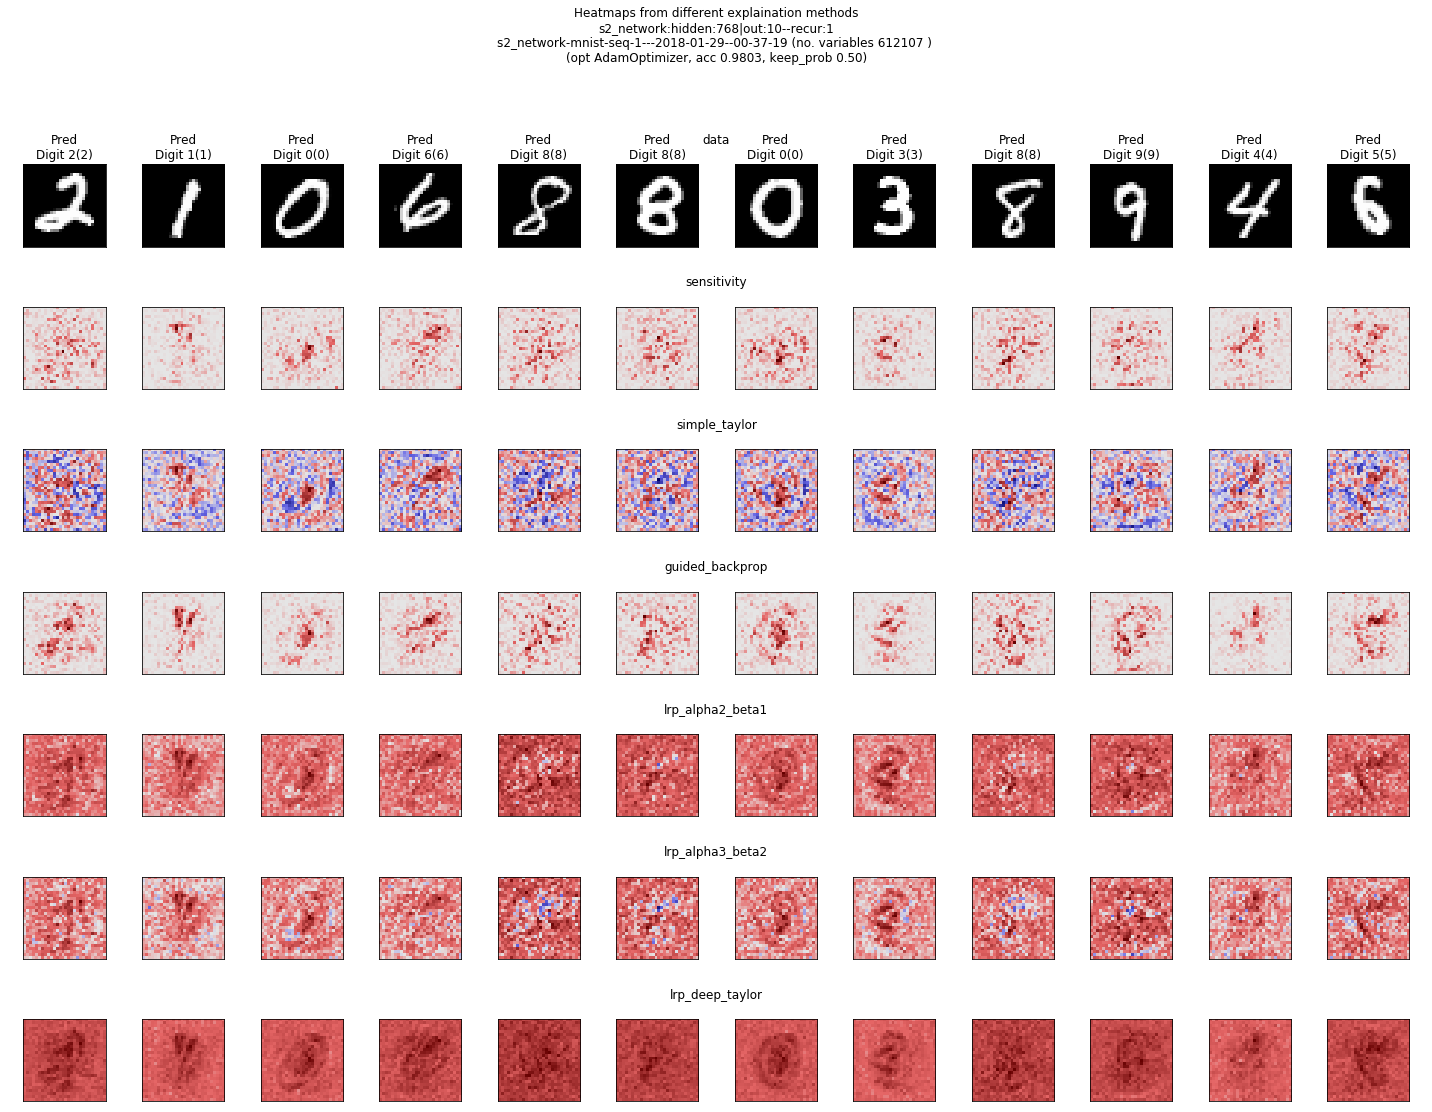

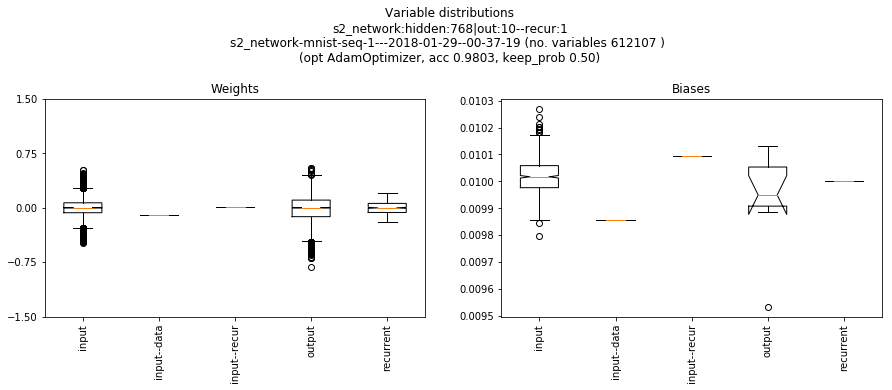

In [10]:
plot_everything('s2', 'mnist', 1)

Positive relevance for model s3_network-mnist-seq-1---2018-01-29--01-07-05
relevance >= 0 : 0.999900


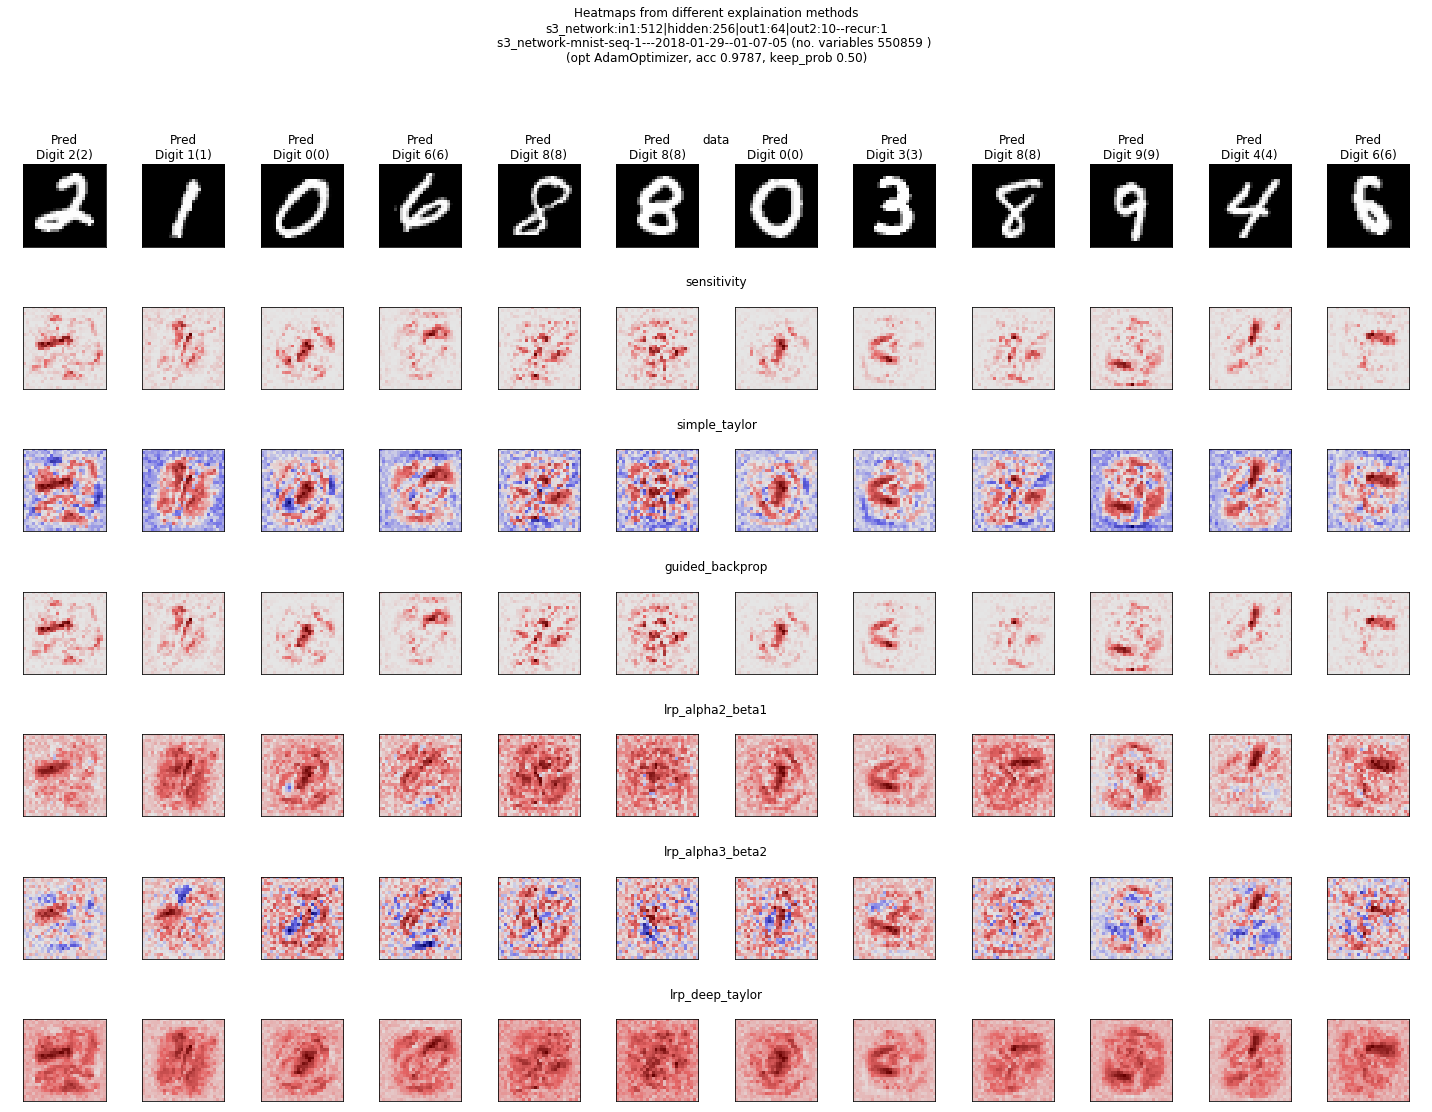

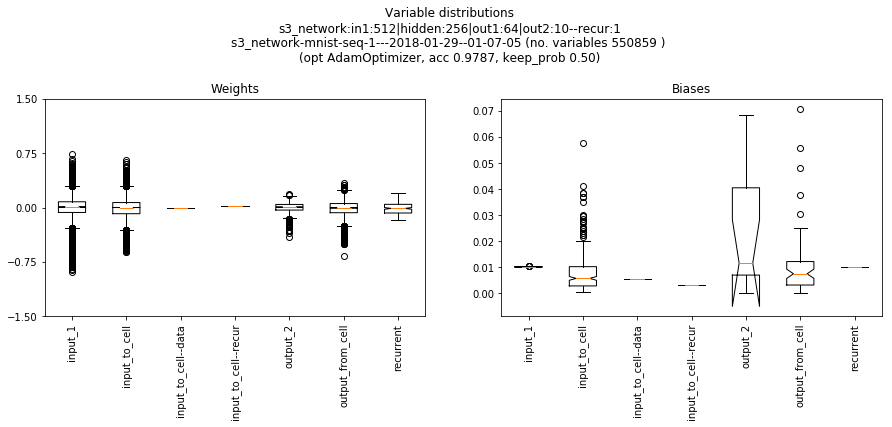

In [11]:
plot_everything('s3', 'mnist', 1)

Positive relevance for model deep_4l_network-mnist-seq-1---2018-01-29--01-45-49
relevance >= 0 : 0.999800


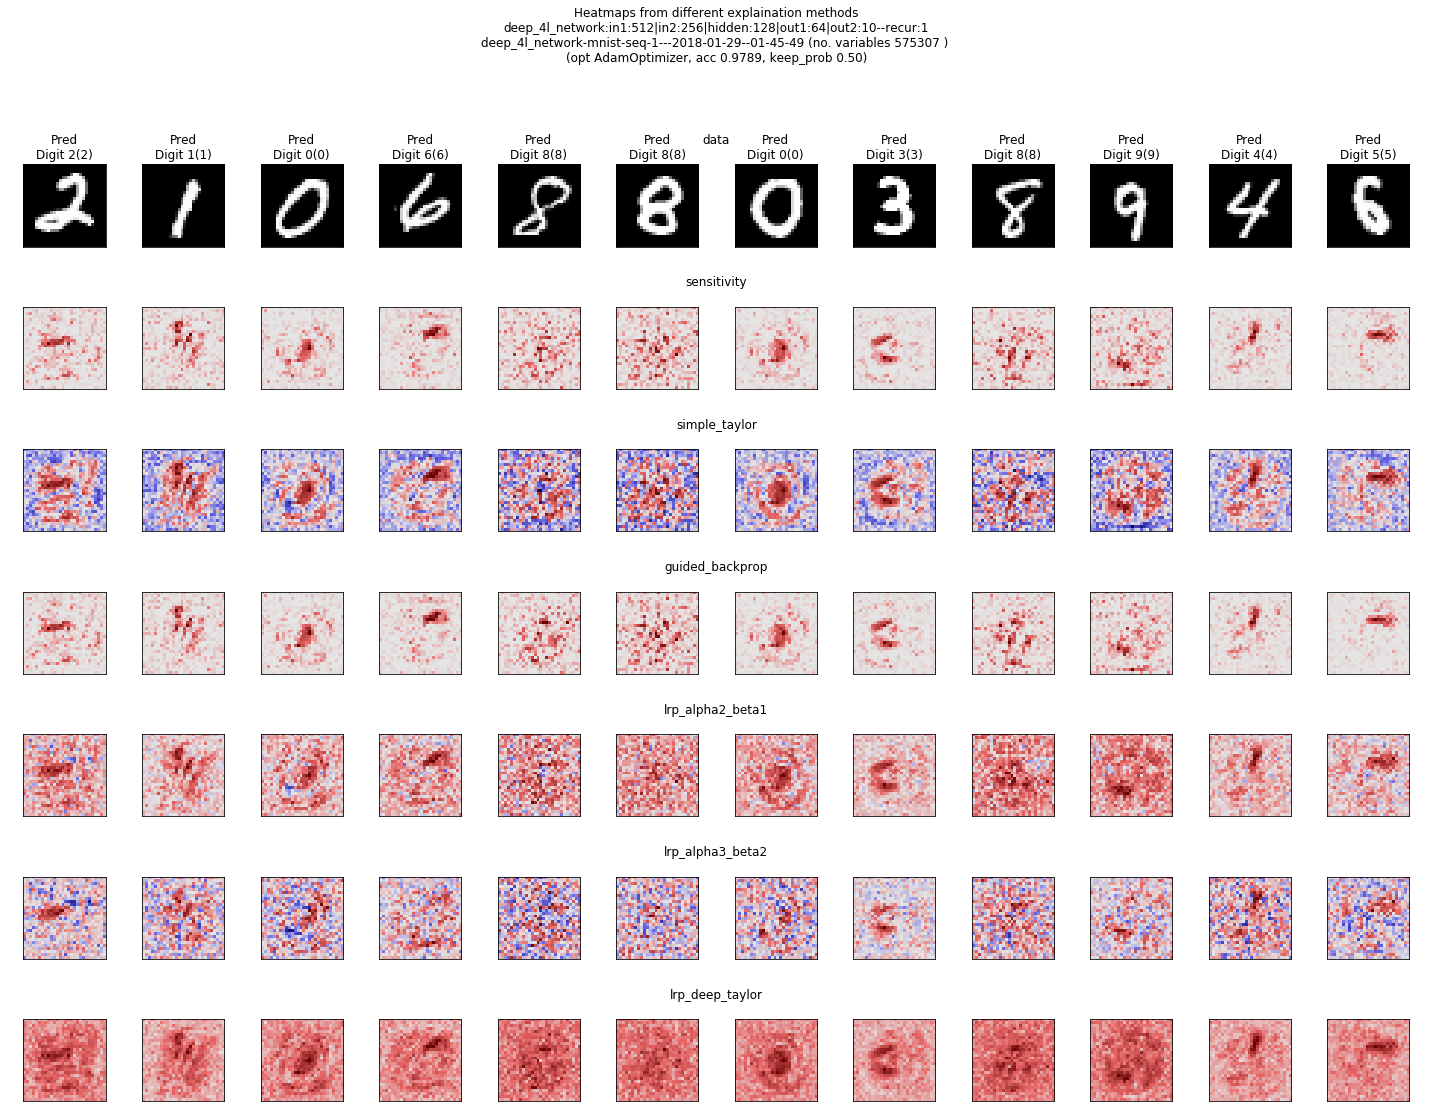

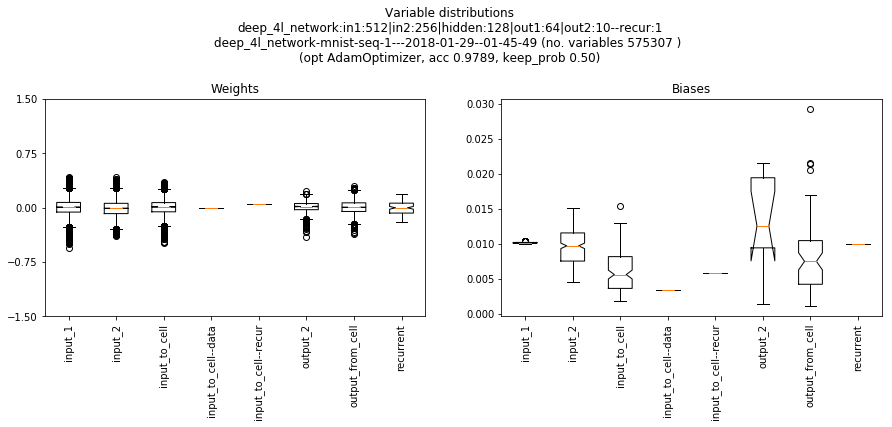

In [12]:
plot_everything('deep_4l', 'mnist', 1)

Positive relevance for model convdeep_4l_network-mnist-seq-1---2018-01-29--23-20-56
relevance >= 0 : 0.999900


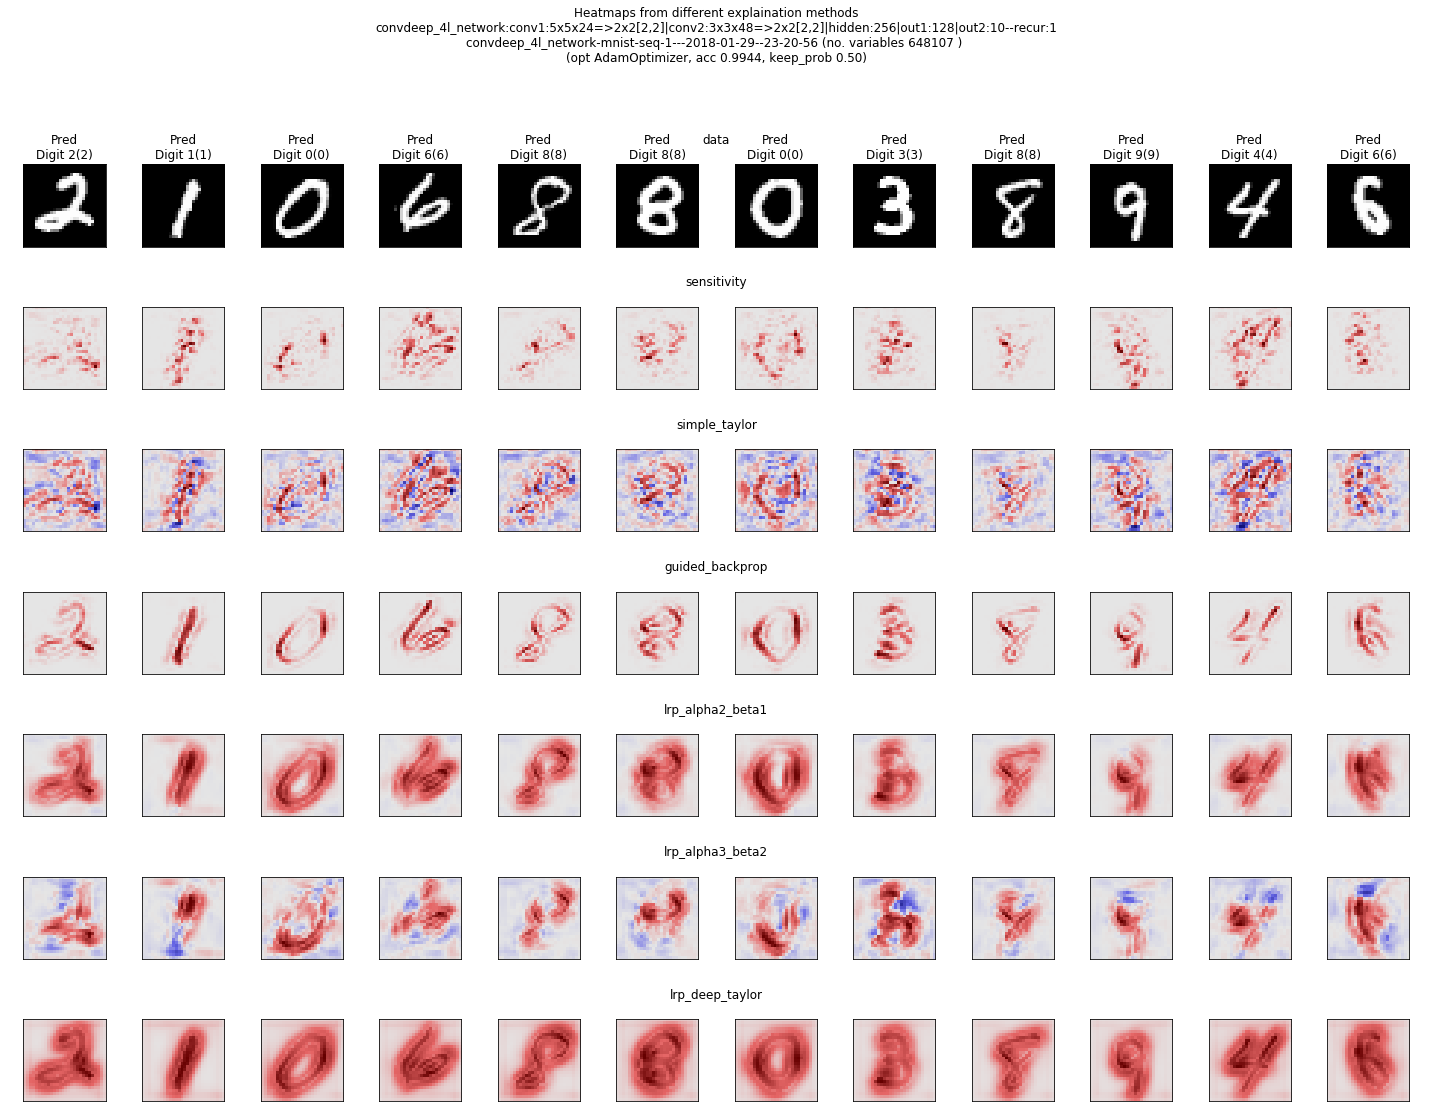

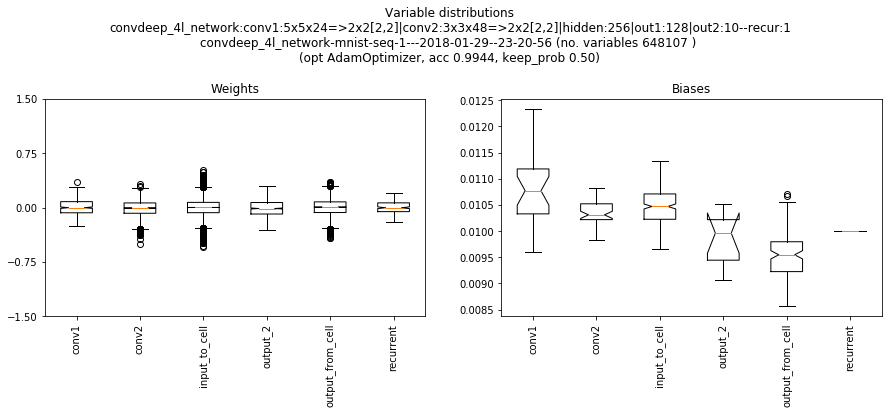

In [13]:
plot_everything('convdeep_4l', 'mnist', 1)

### FashionMNIST

Positive relevance for model s2_network-fashion-mnist-seq-1---2018-01-29--00-52-14
relevance >= 0 : 0.989000


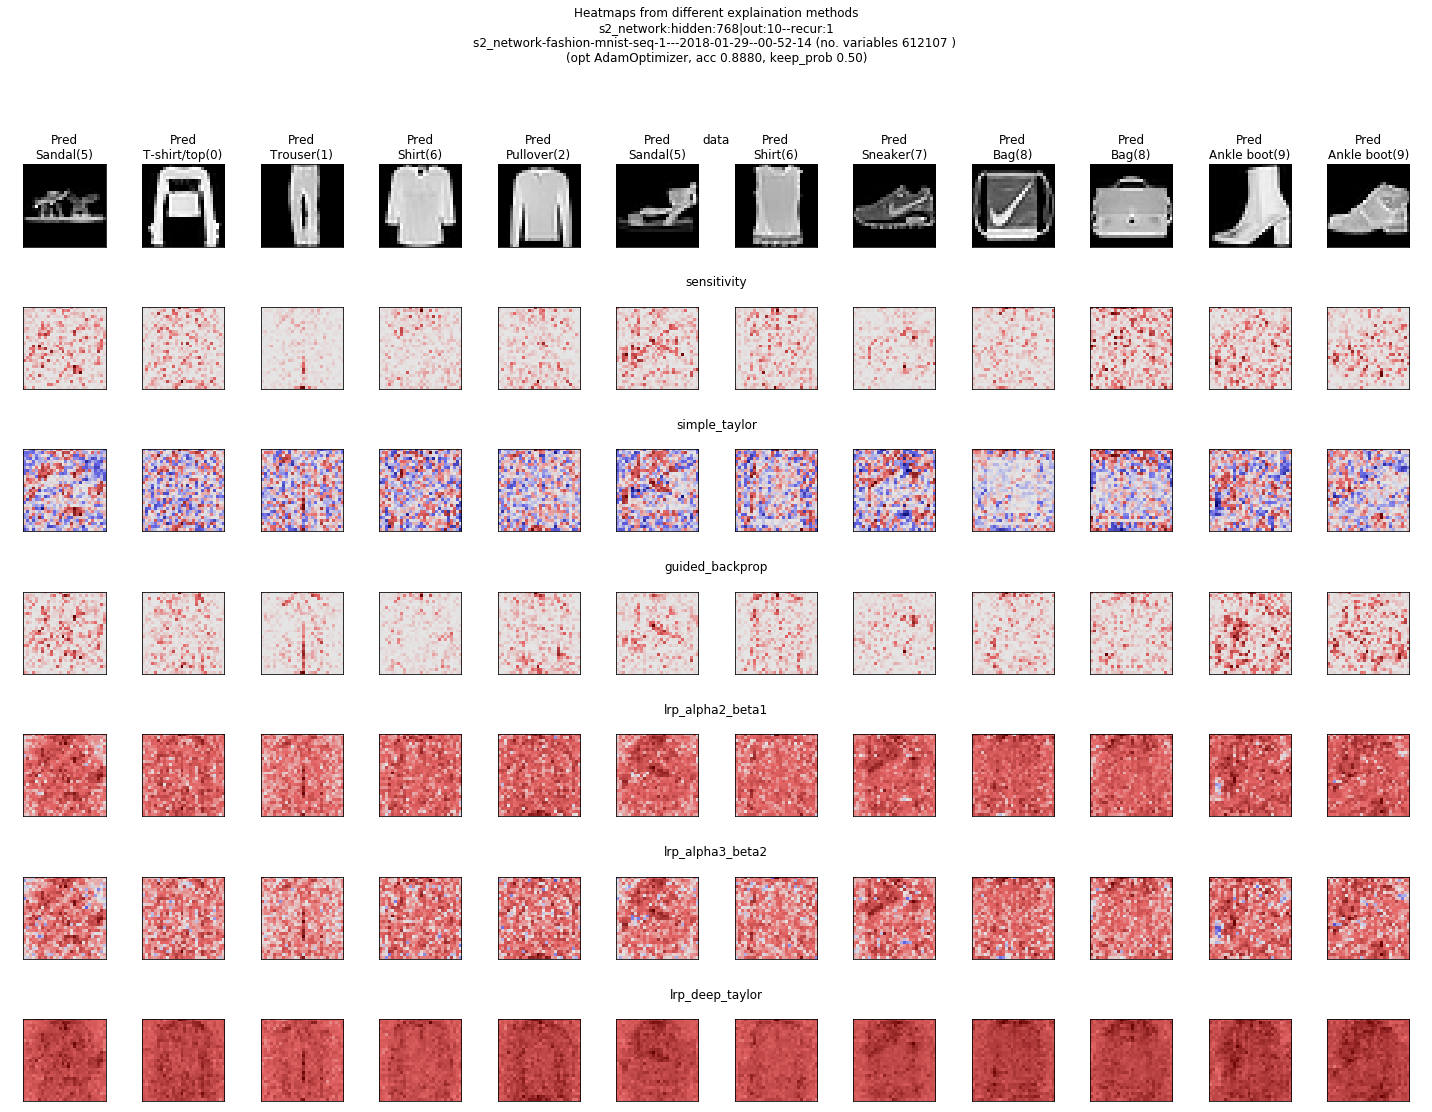

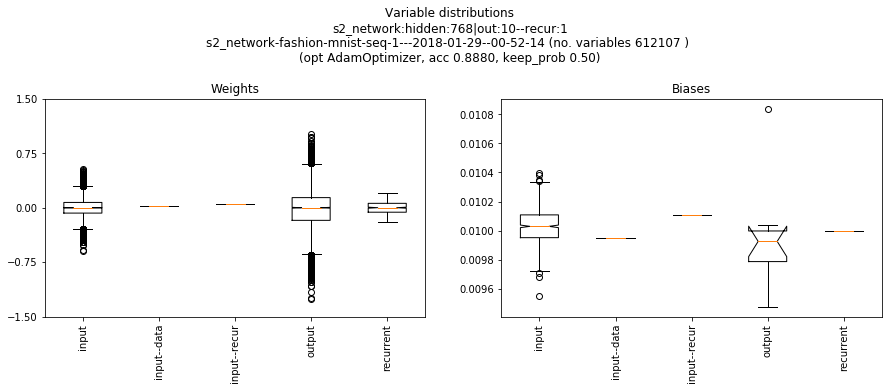

In [14]:
plot_everything('s2', 'fashion-mnist', 1)

Positive relevance for model s3_network-fashion-mnist-seq-1---2018-01-29--01-26-10
relevance >= 0 : 0.999600


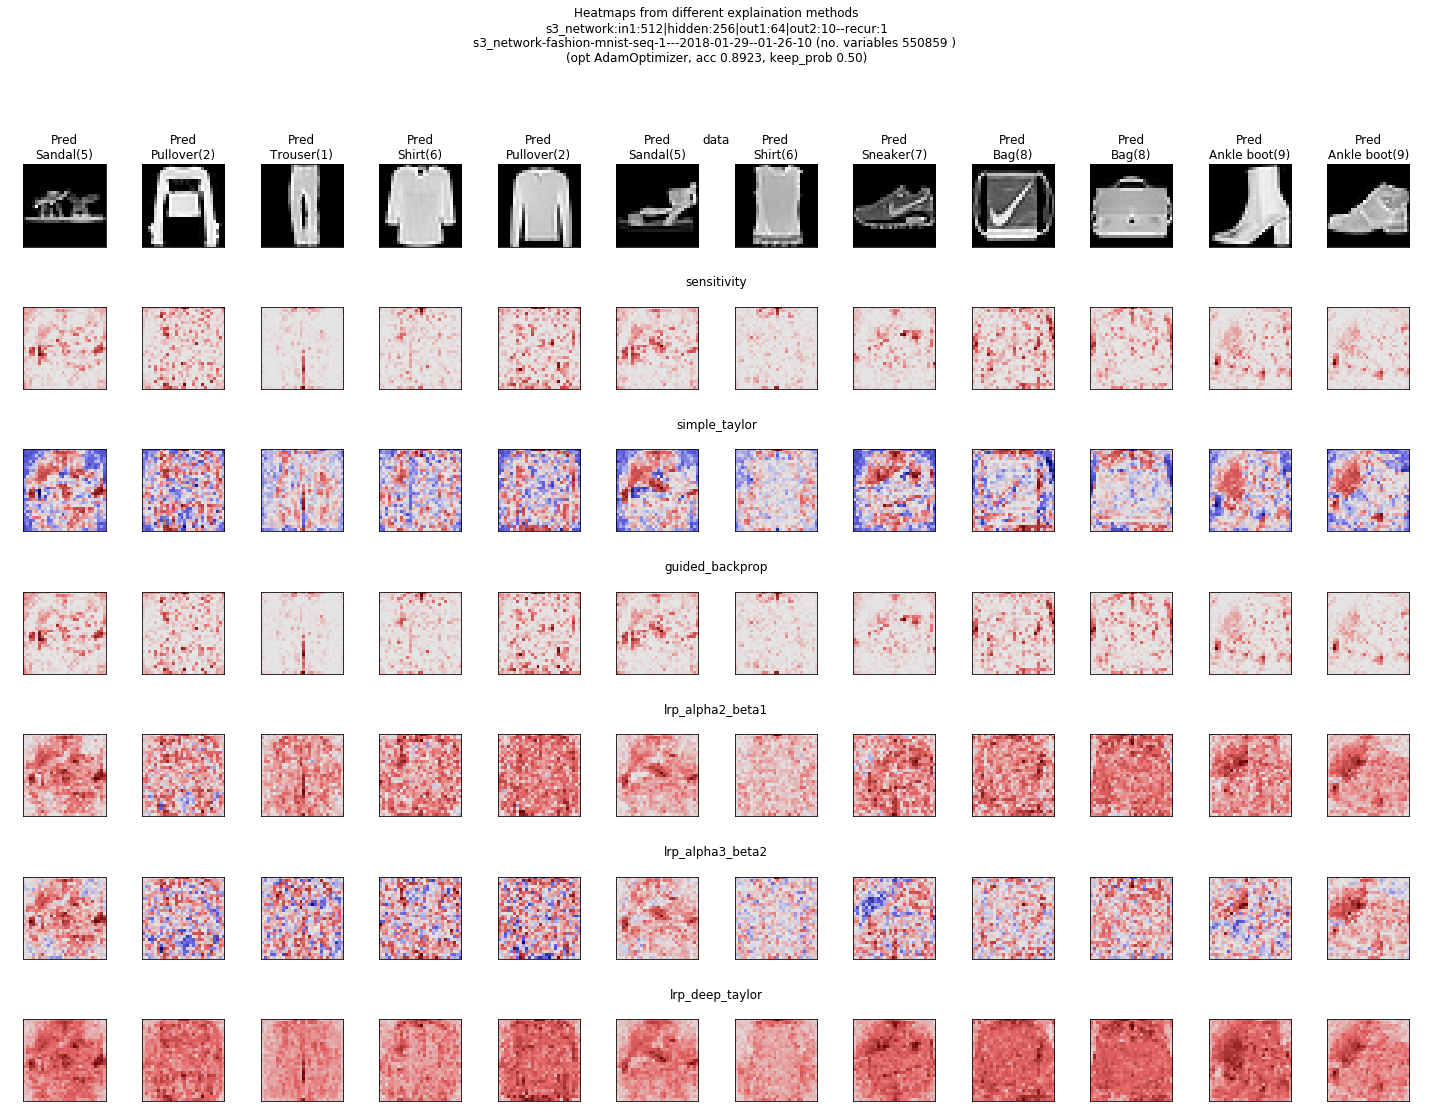

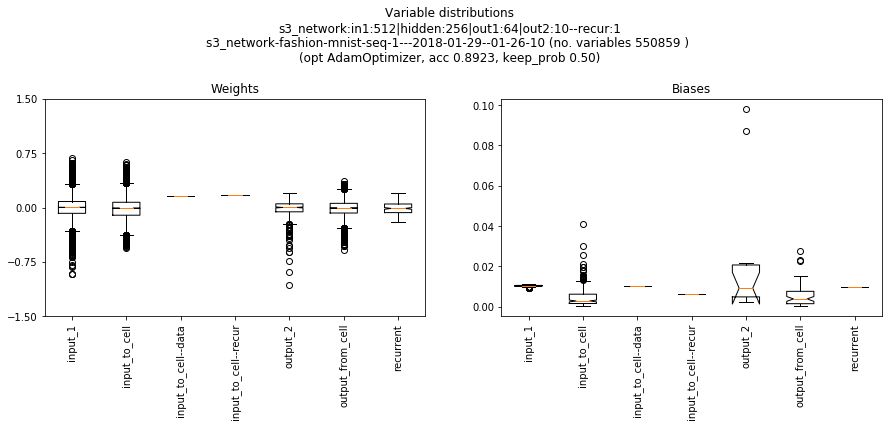

In [15]:
plot_everything('s3', 'fashion-mnist', 1)

Positive relevance for model deep_4l_network-fashion-mnist-seq-1---2018-01-29--02-08-17
relevance >= 0 : 0.999500


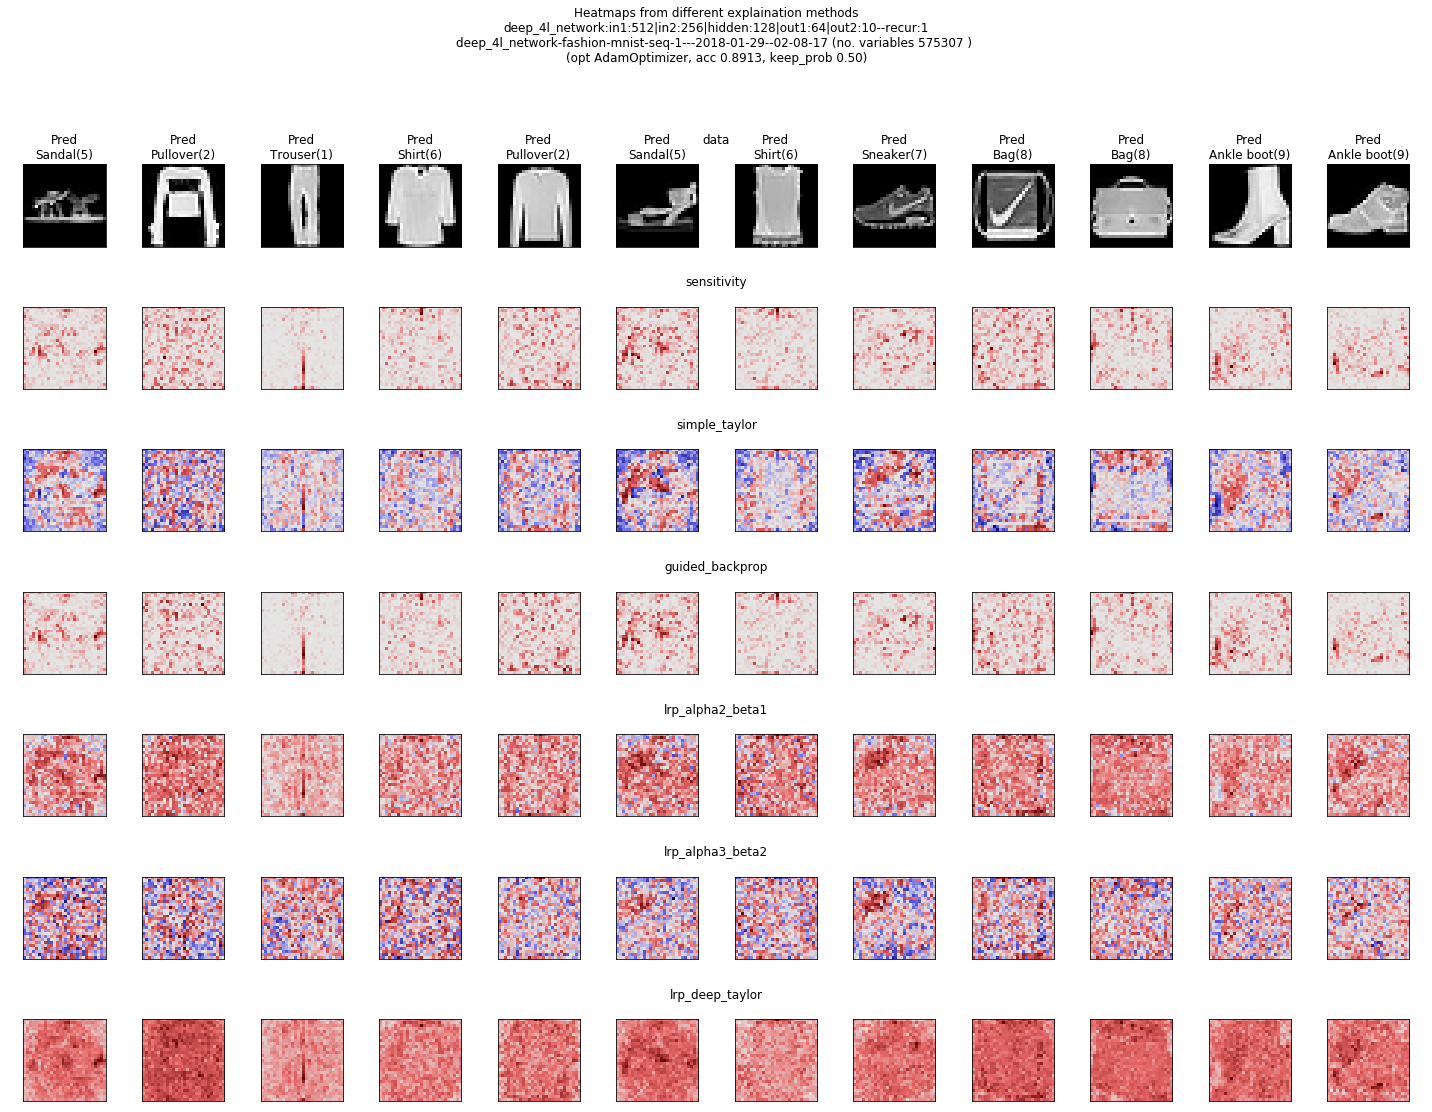

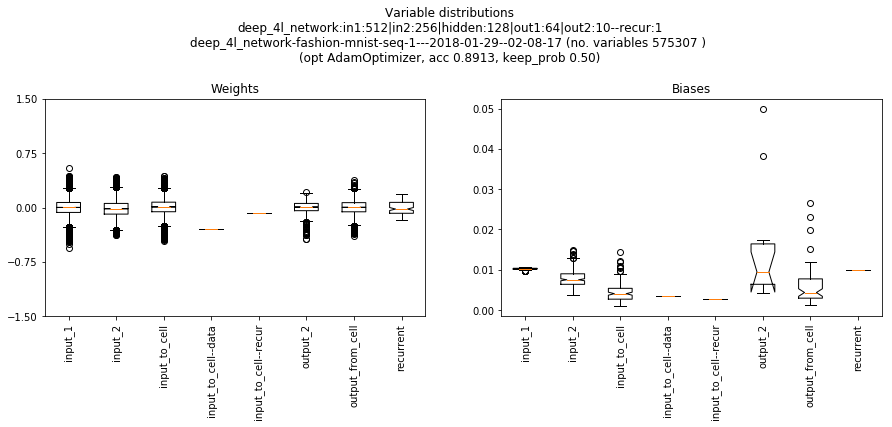

In [16]:
plot_everything('deep_4l', 'fashion-mnist', 1)

Positive relevance for model convdeep_4l_network-fashion-mnist-seq-1---2018-01-30--20-29-56
relevance >= 0 : 0.999100


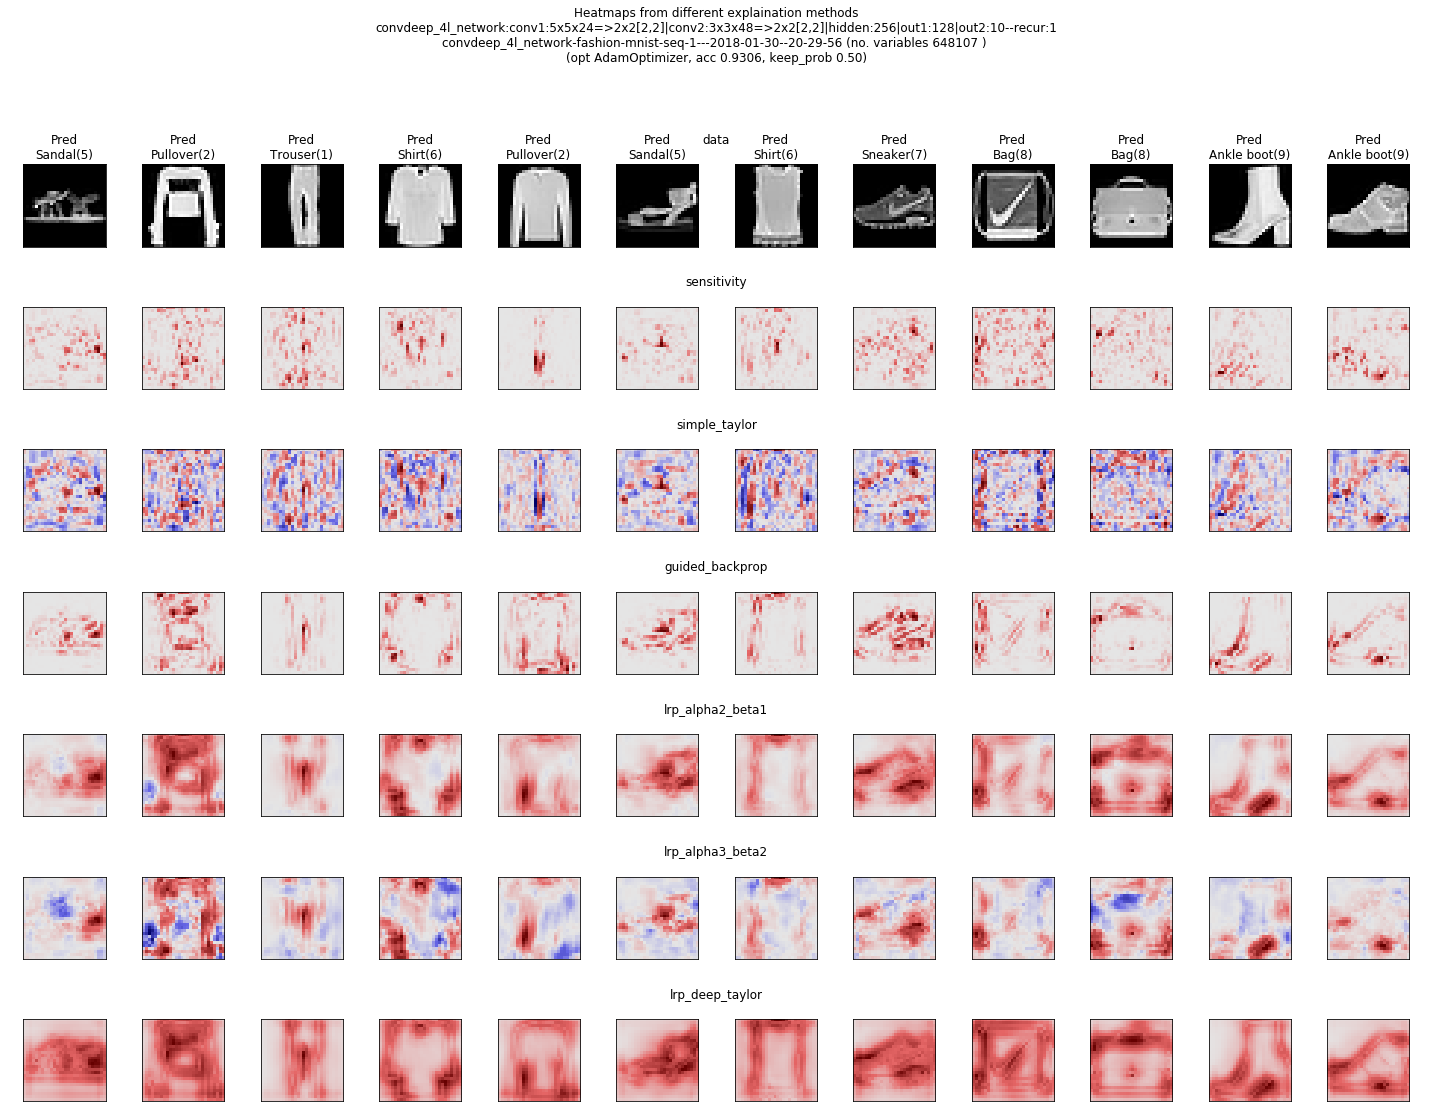

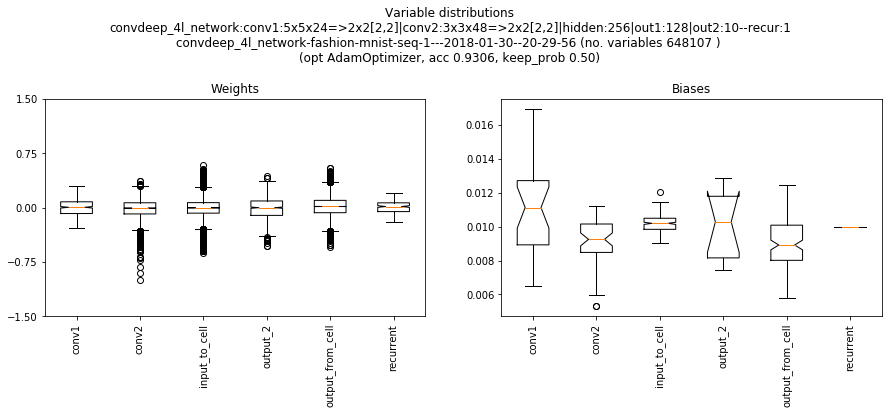

In [17]:
plot_everything('convdeep_4l', 'fashion-mnist', 1)

## Seq 4

### MNIST

Positive relevance for model s2_network-mnist-seq-4---2018-01-28--15-42-21
relevance >= 0 : 0.992300


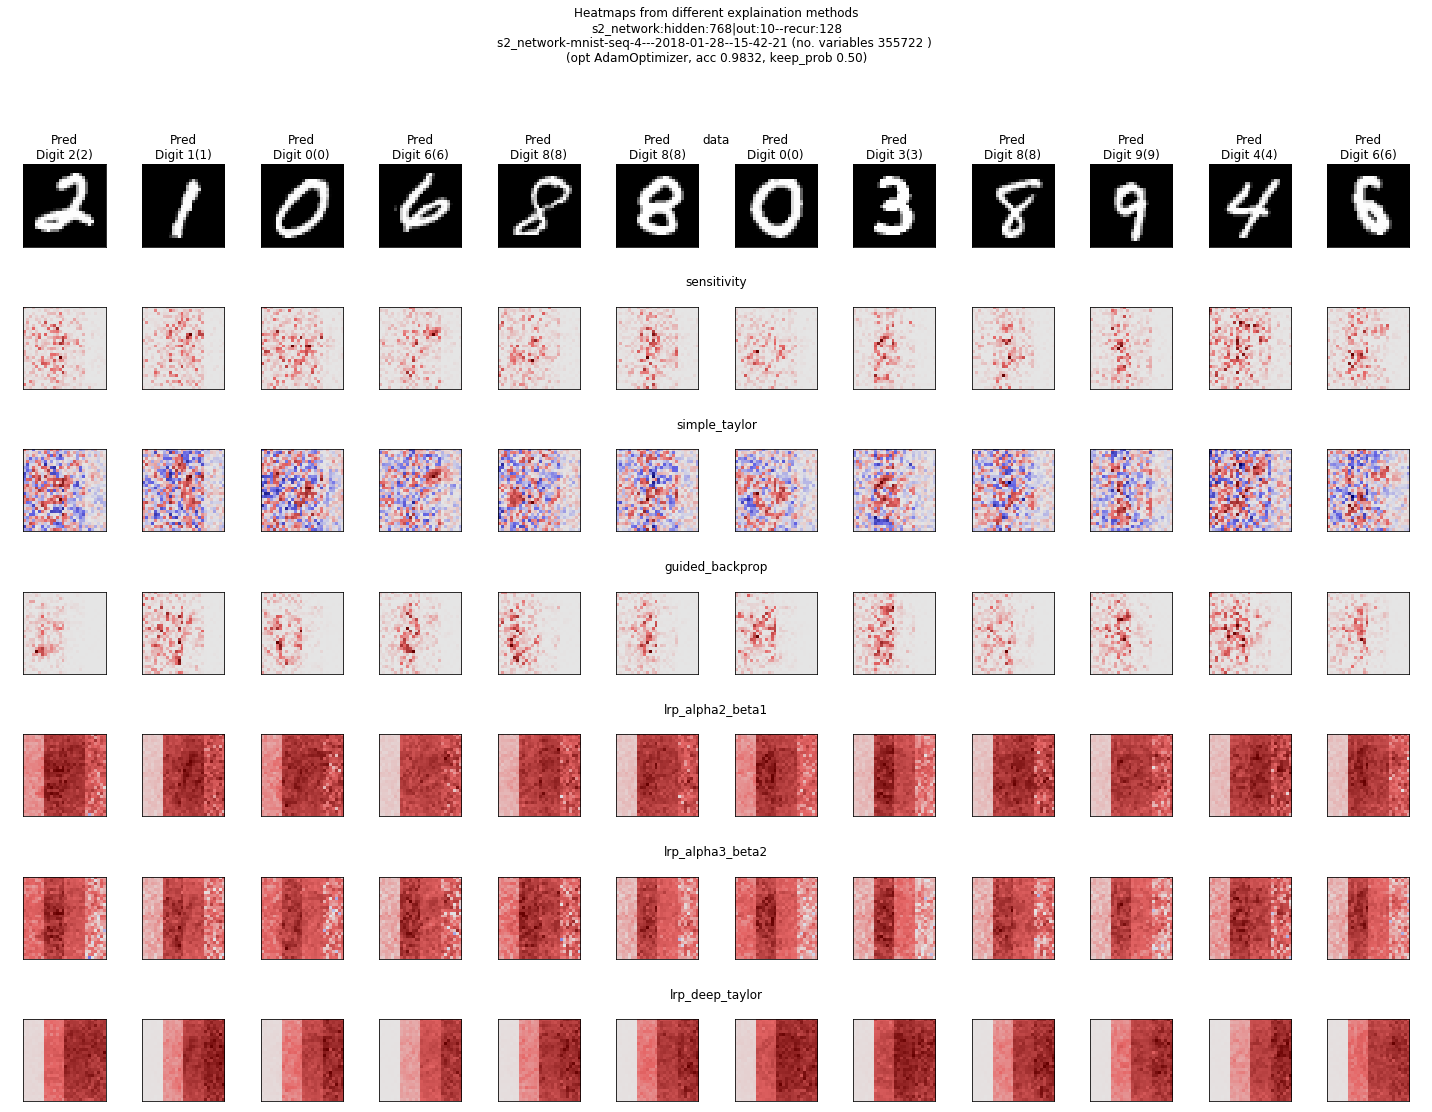

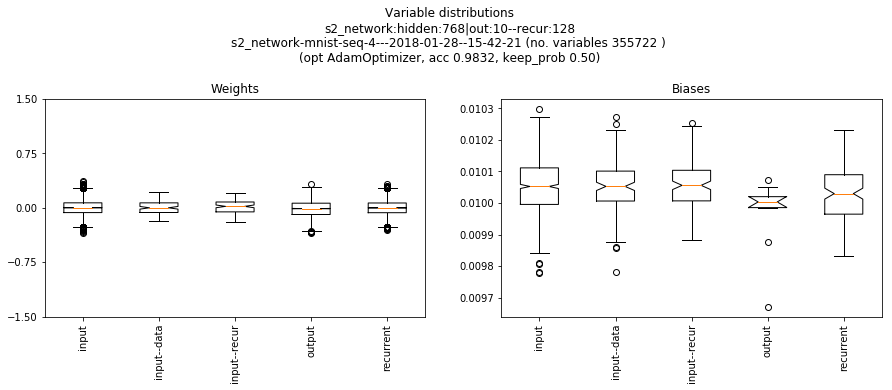

In [18]:
plot_everything('s2', 'mnist', 4)

Positive relevance for model s3_network-mnist-seq-4---2018-01-28--17-07-01
relevance >= 0 : 1.000000


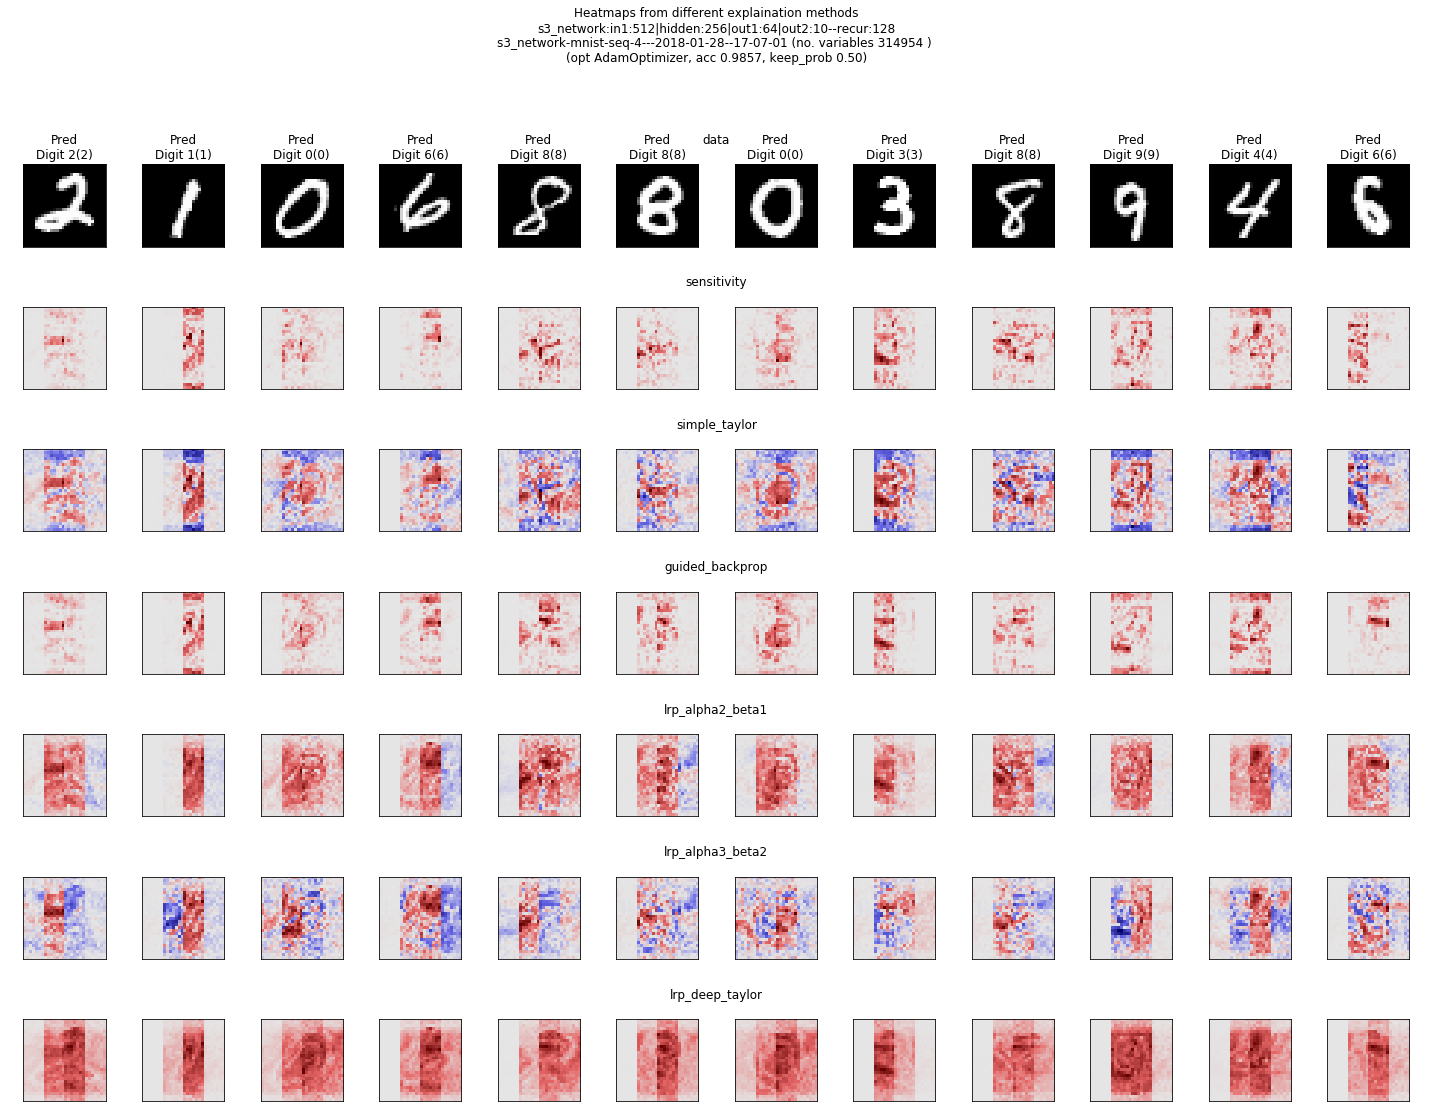

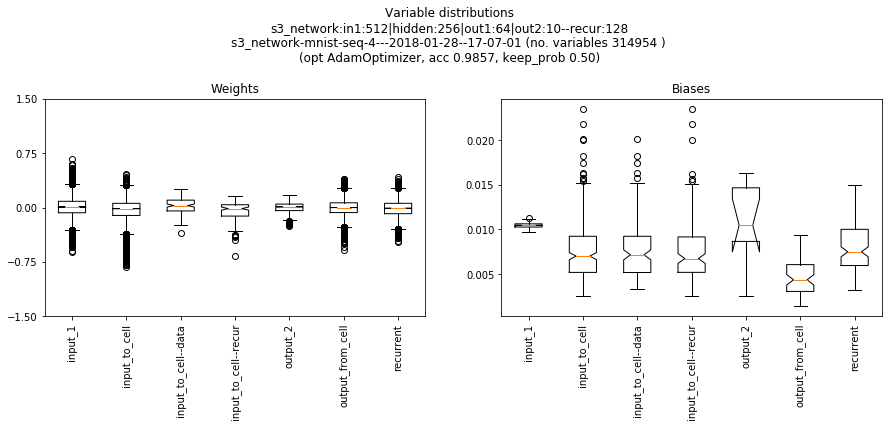

In [19]:
plot_everything('s3', 'mnist', 4)

Positive relevance for model deep_4l_network-mnist-seq-4---2018-01-28--19-04-09
relevance >= 0 : 1.000000


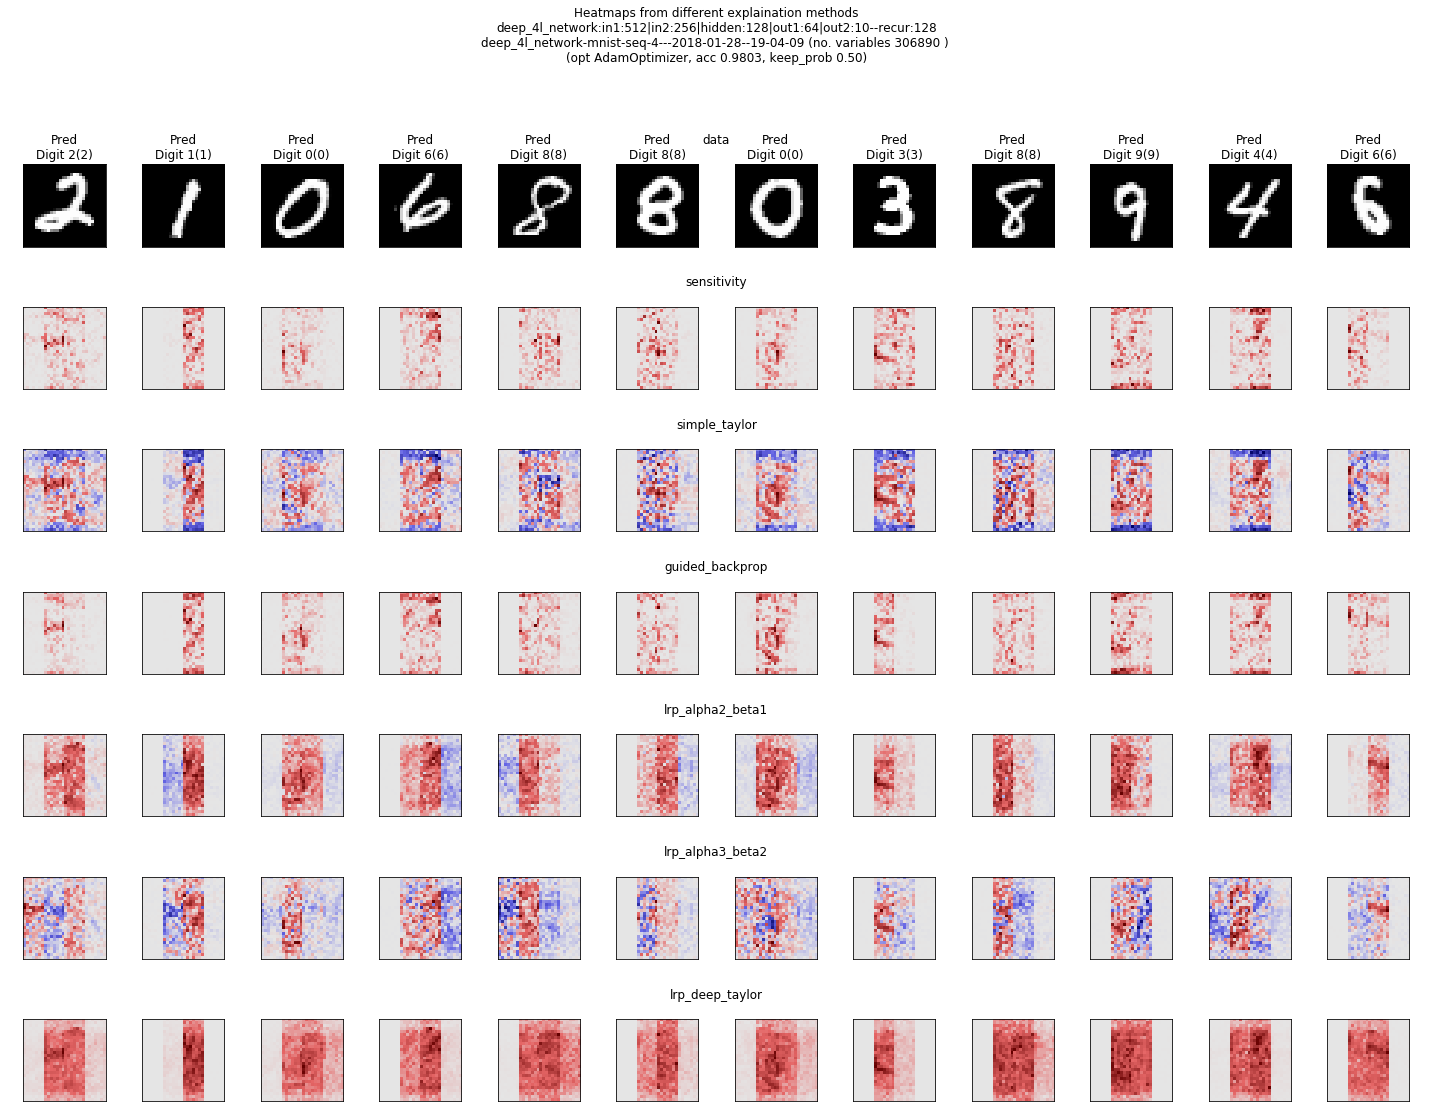

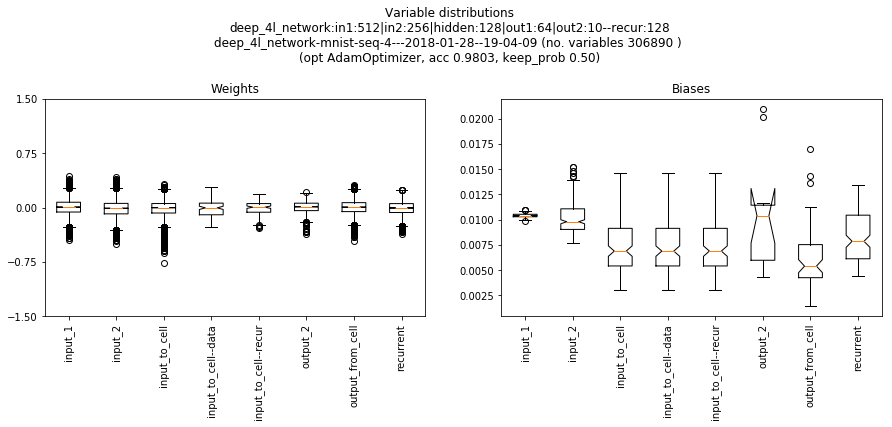

In [20]:
plot_everything('deep_4l', 'mnist', 4)

Positive relevance for model convdeep_4l_network-mnist-seq-4---2018-01-30--21-22-36
relevance >= 0 : 0.999800


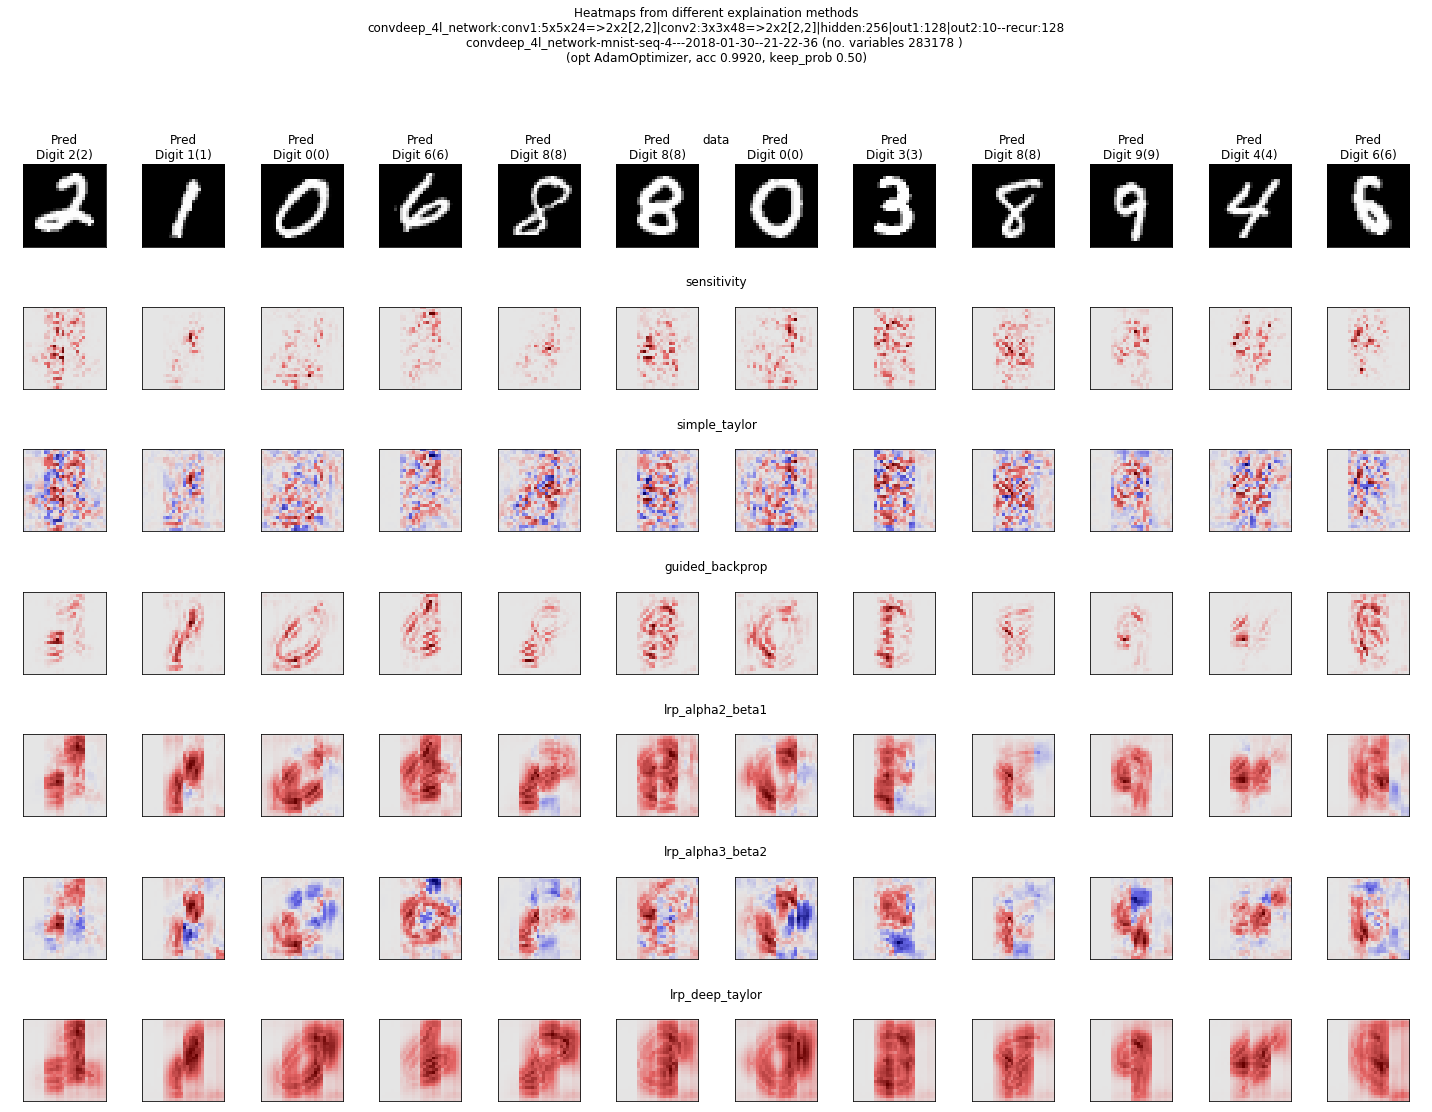

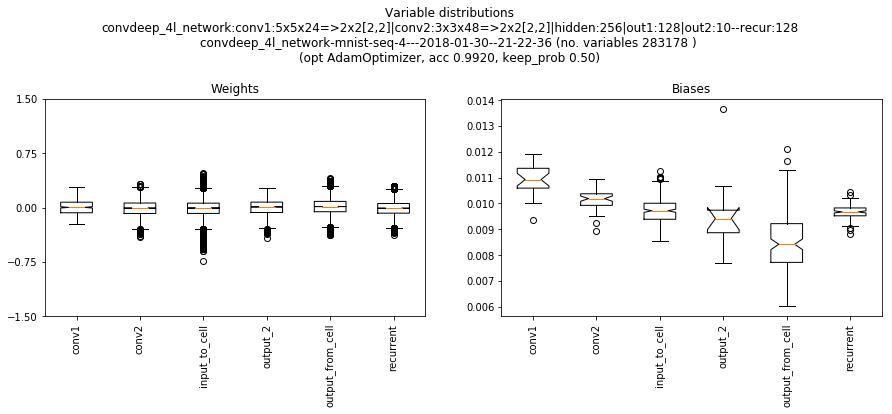

In [21]:
plot_everything('convdeep_4l', 'mnist', 4)

### FashionMNIST

Positive relevance for model s2_network-fashion-mnist-seq-4---2018-01-28--16-19-12
relevance >= 0 : 0.985000


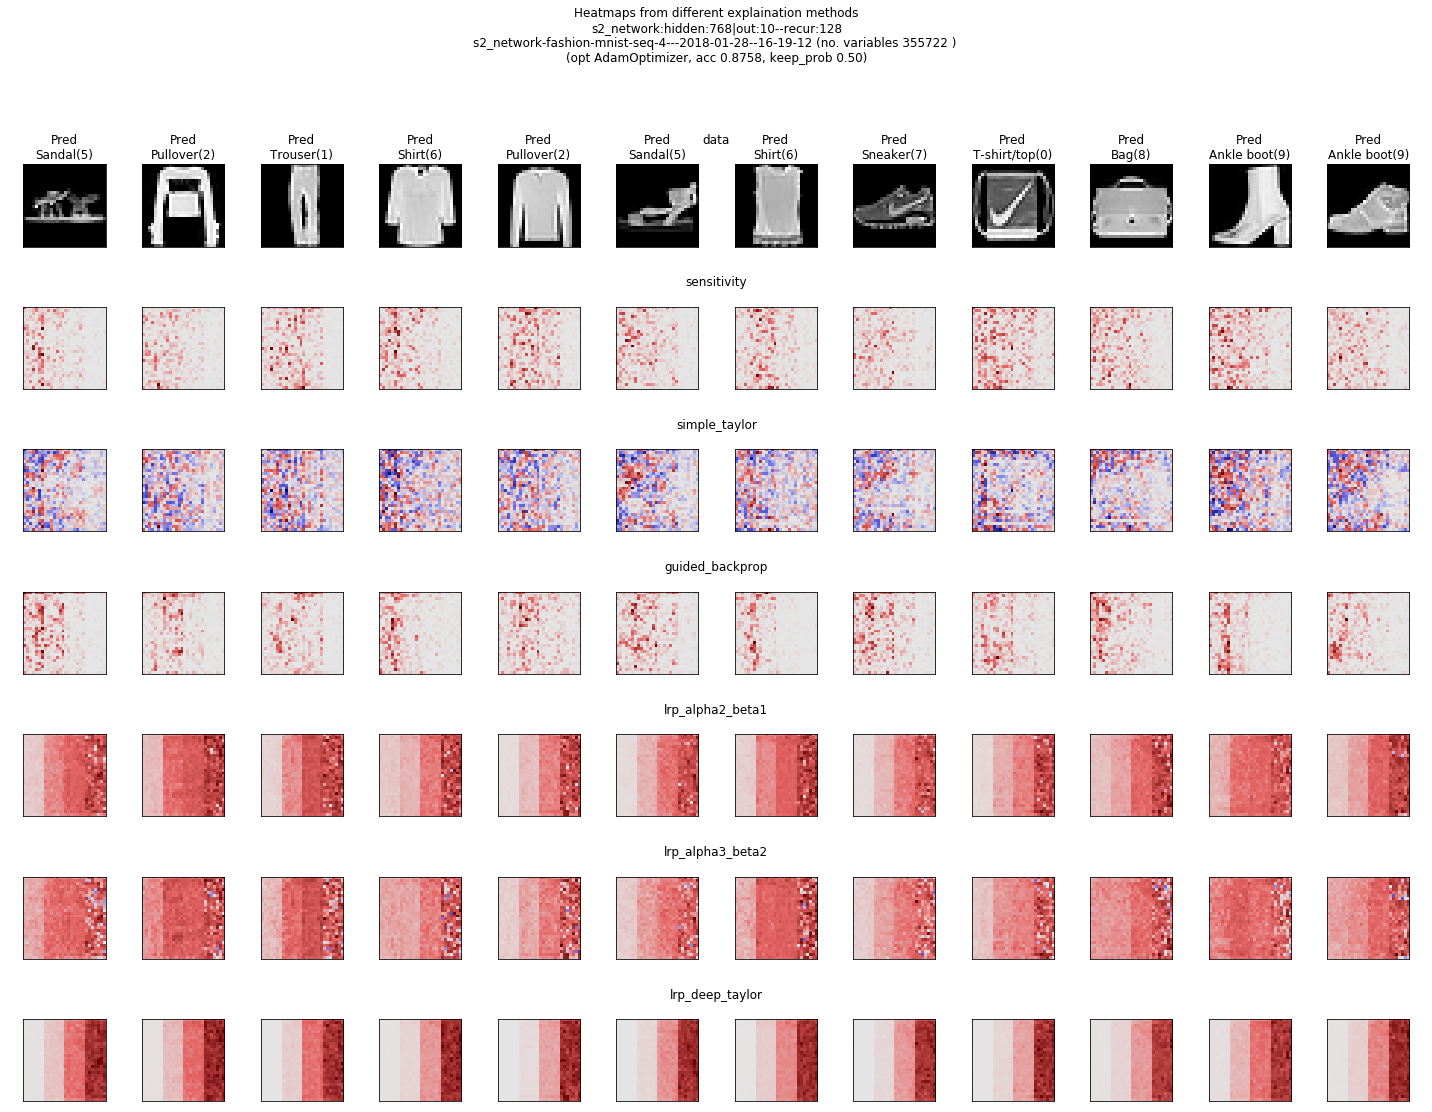

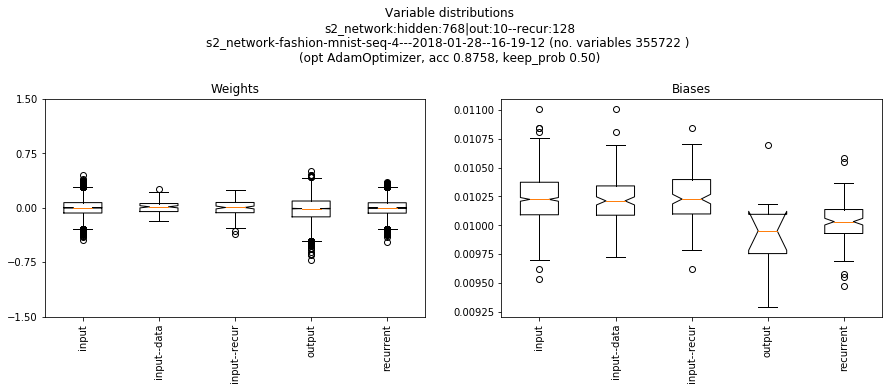

In [22]:
plot_everything('s2', 'fashion-mnist', 4)

Positive relevance for model s3_network-fashion-mnist-seq-4---2018-01-28--18-03-59
relevance >= 0 : 0.999800


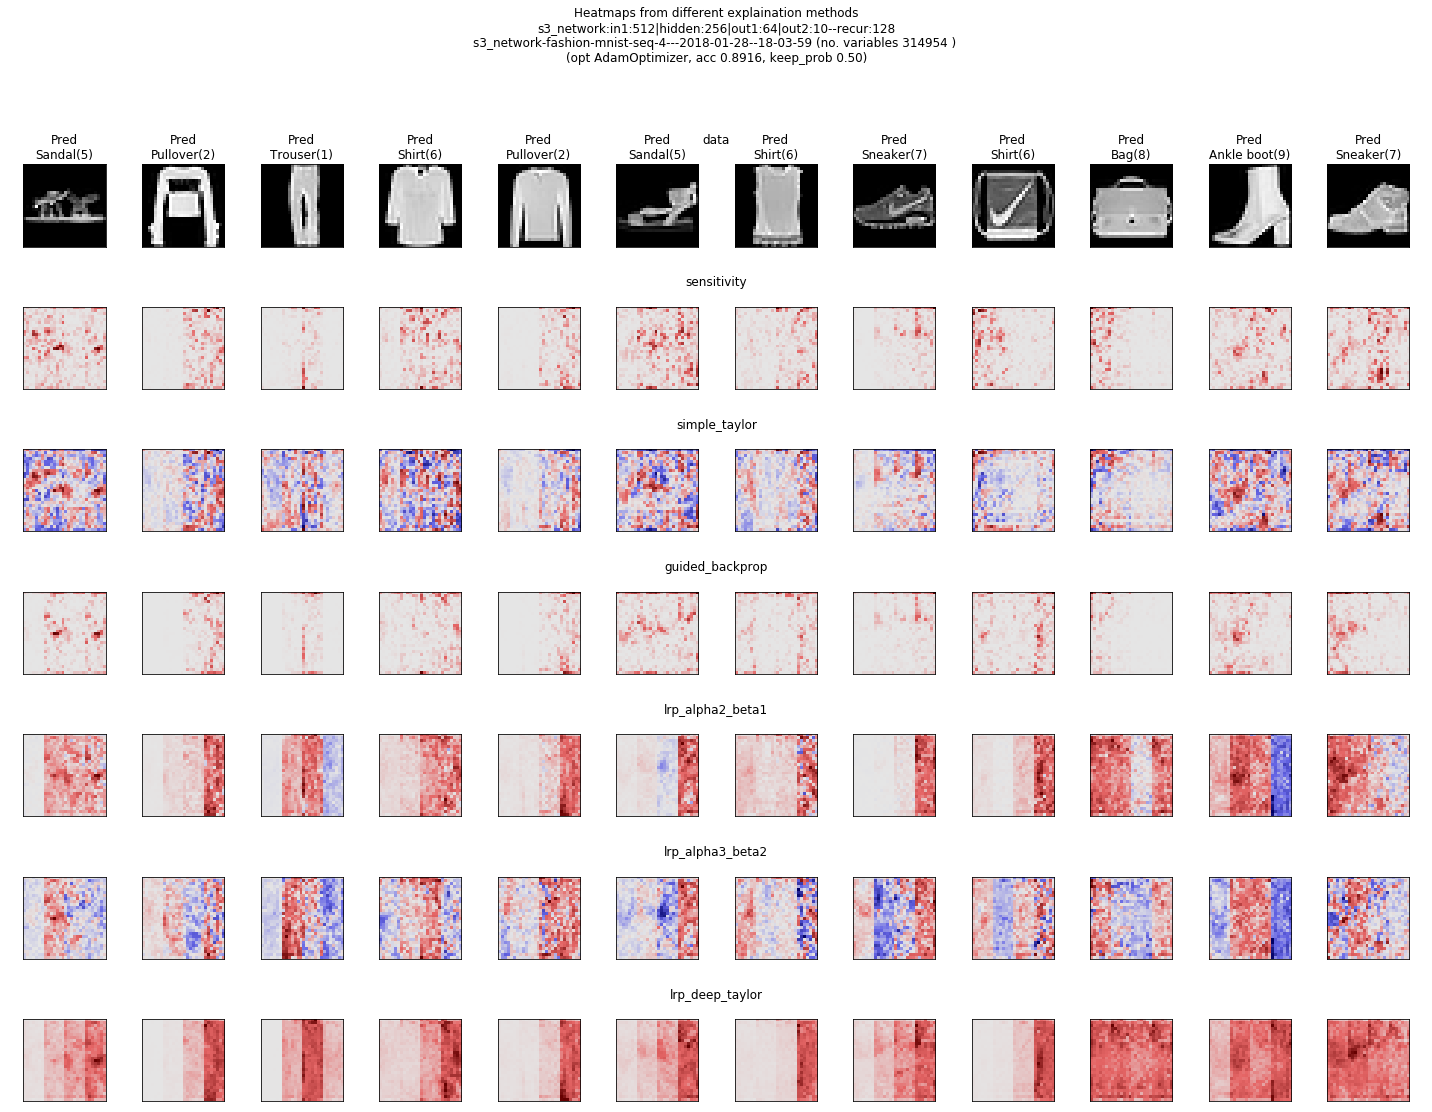

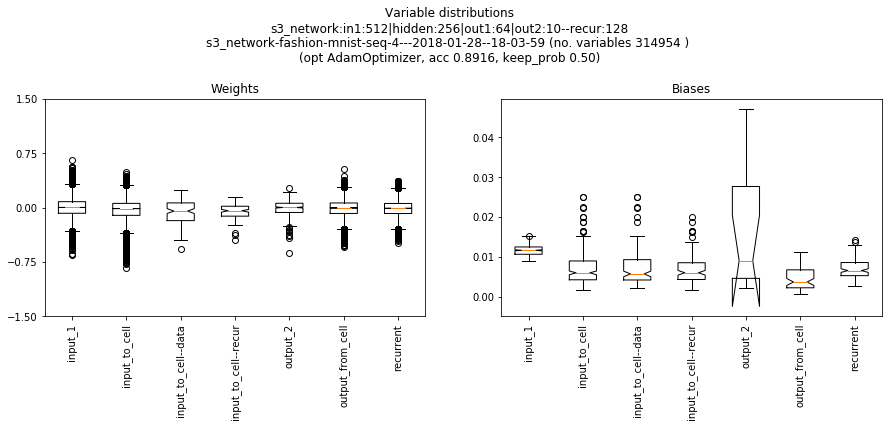

In [23]:
plot_everything('s3', 'fashion-mnist', 4)

Positive relevance for model deep_4l_network-fashion-mnist-seq-4---2018-01-28--20-11-05
relevance >= 0 : 0.999800


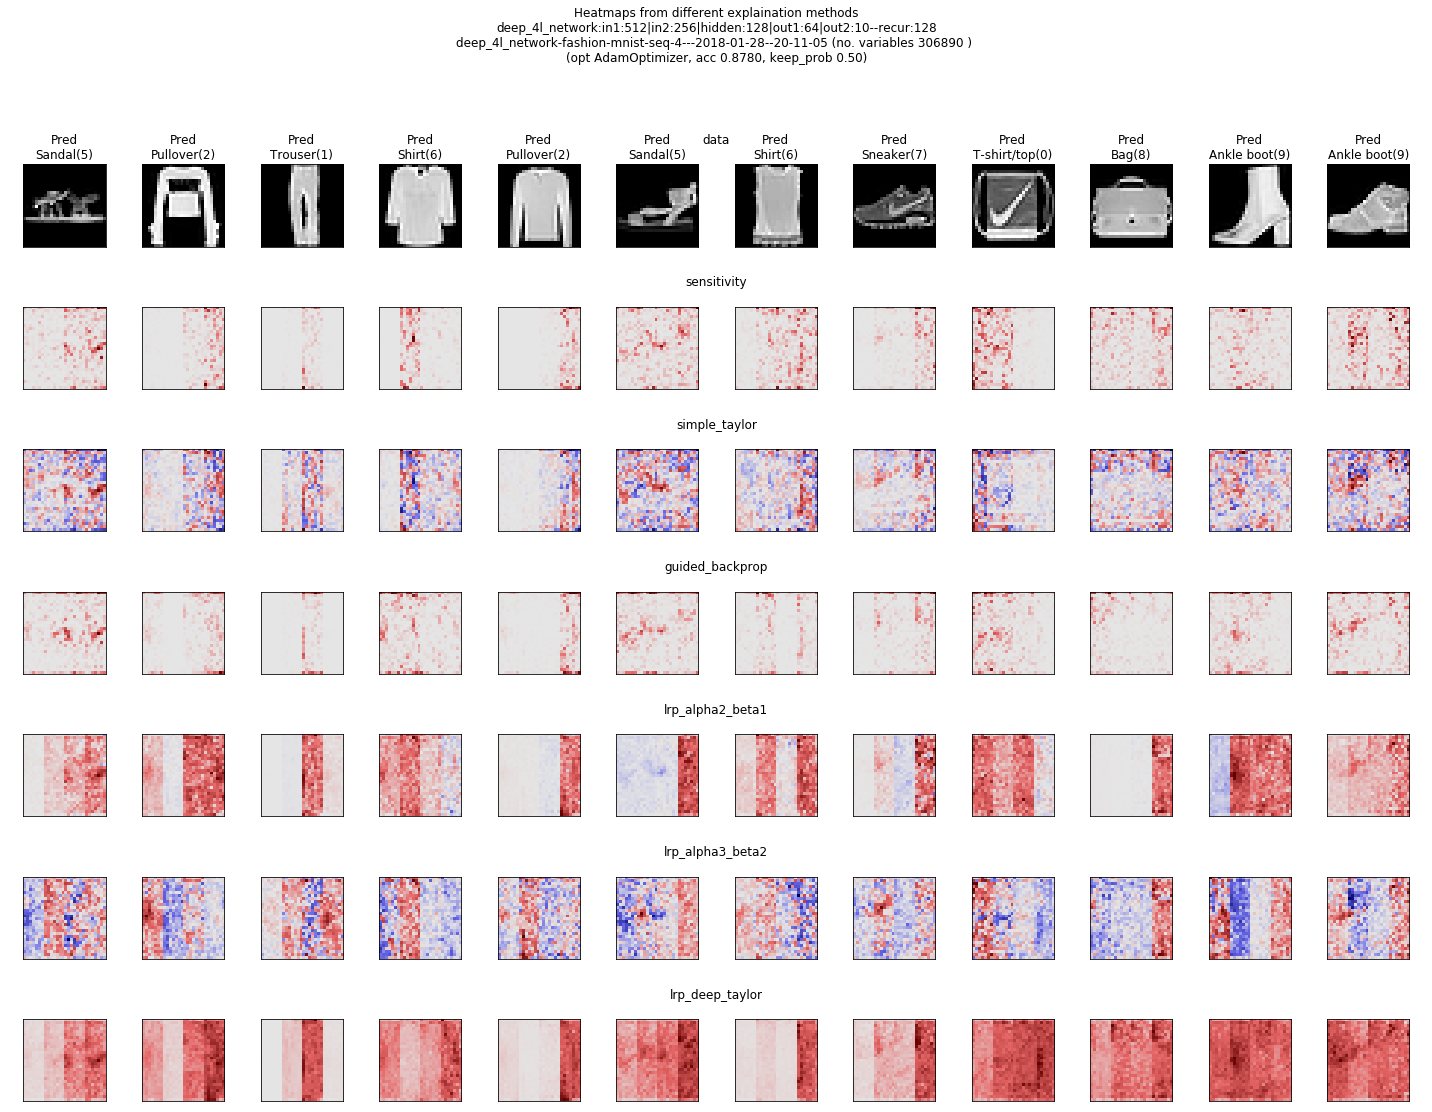

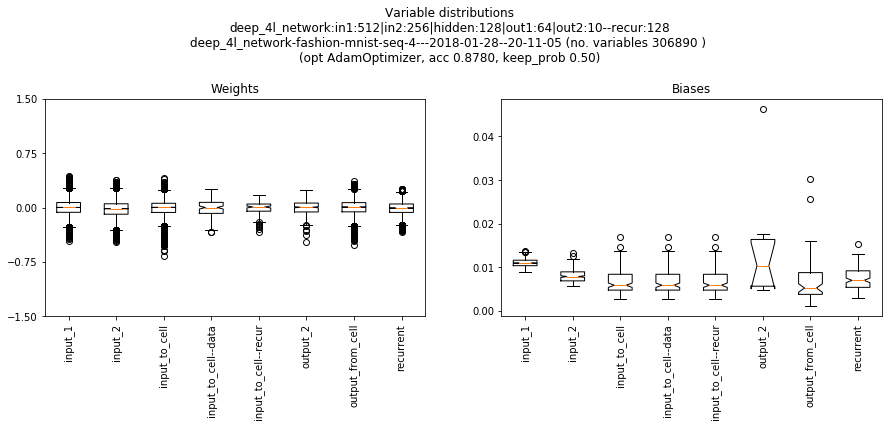

In [24]:
plot_everything('deep_4l', 'fashion-mnist', 4)

Positive relevance for model convdeep_4l_network-fashion-mnist-seq-4---2018-01-31--10-02-25
relevance >= 0 : 0.999500


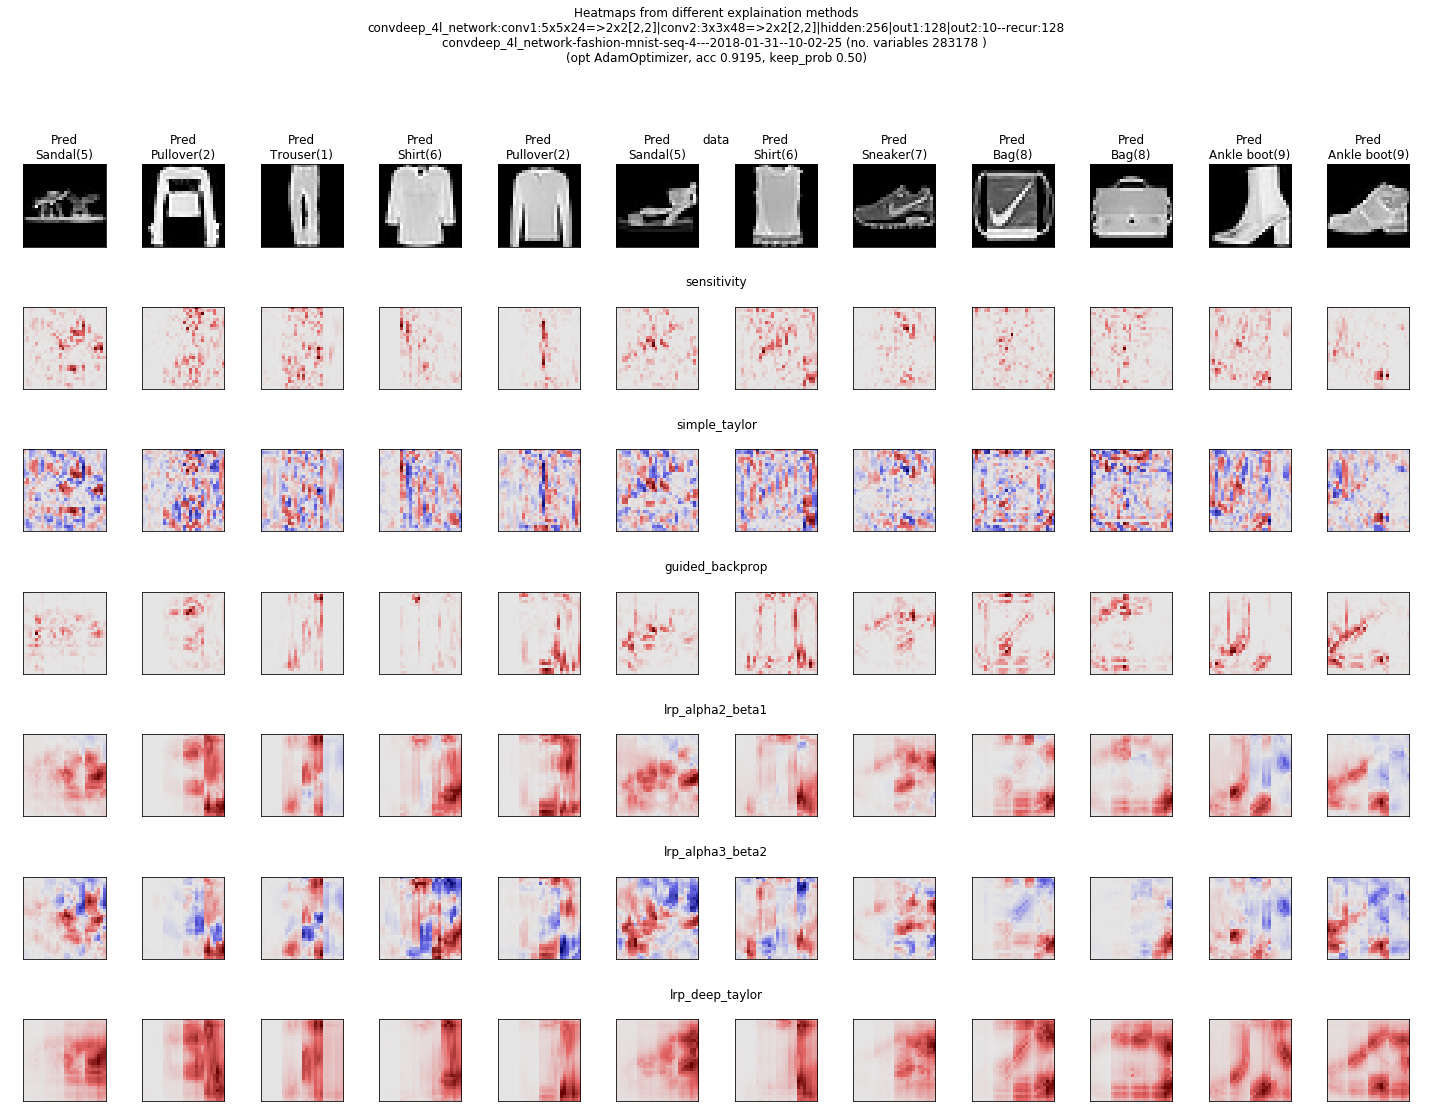

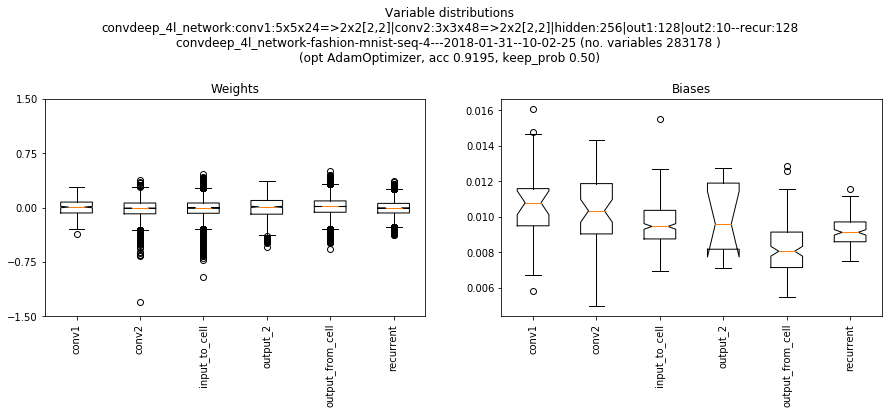

In [25]:
plot_everything('convdeep_4l', 'fashion-mnist', 4)

## Seq 7

### MNIST

Positive relevance for model s2_network-mnist-seq-7---2018-01-28--15-58-49
relevance >= 0 : 0.992800


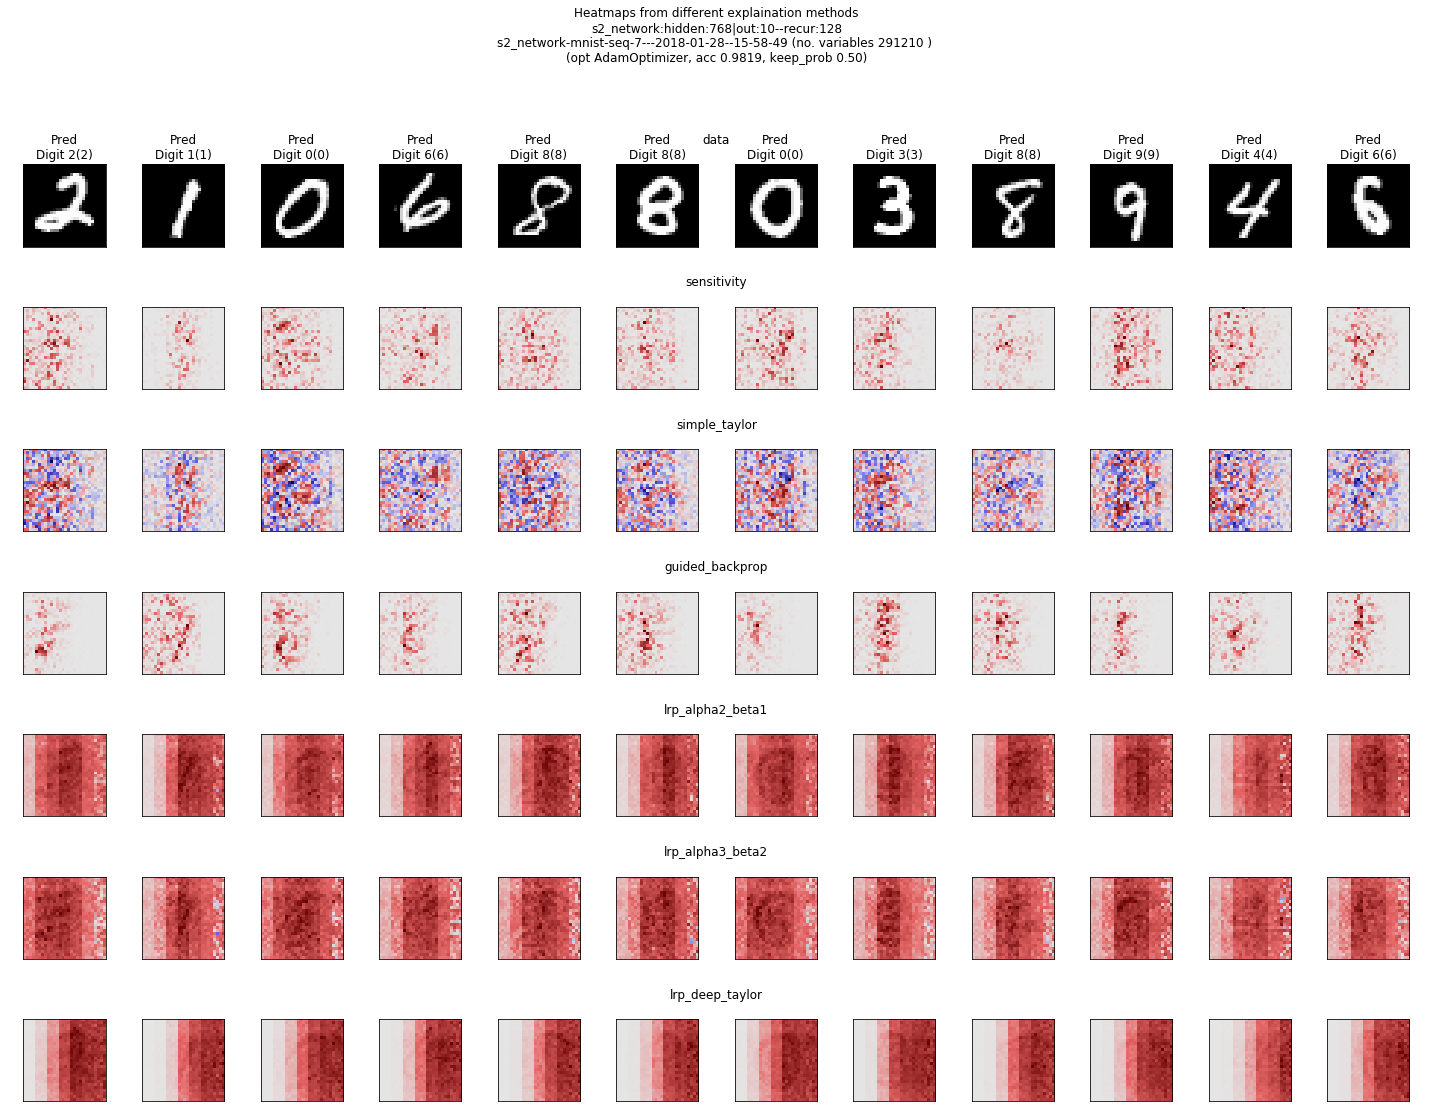

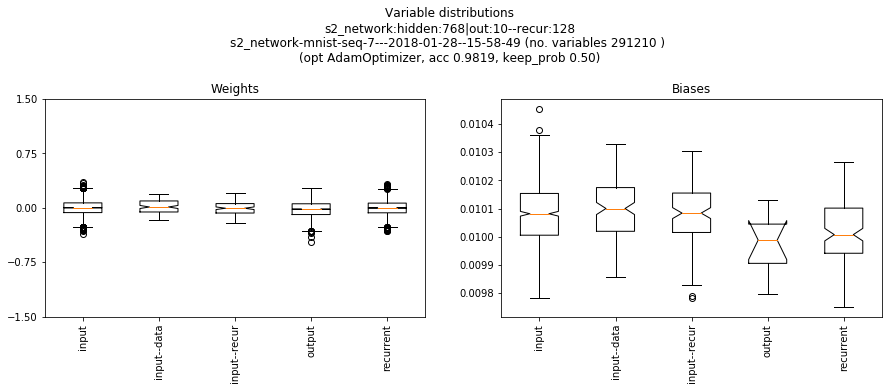

In [26]:
plot_everything('s2', 'mnist', 7)

Positive relevance for model s3_network-mnist-seq-7---2018-01-28--17-31-06
relevance >= 0 : 1.000000


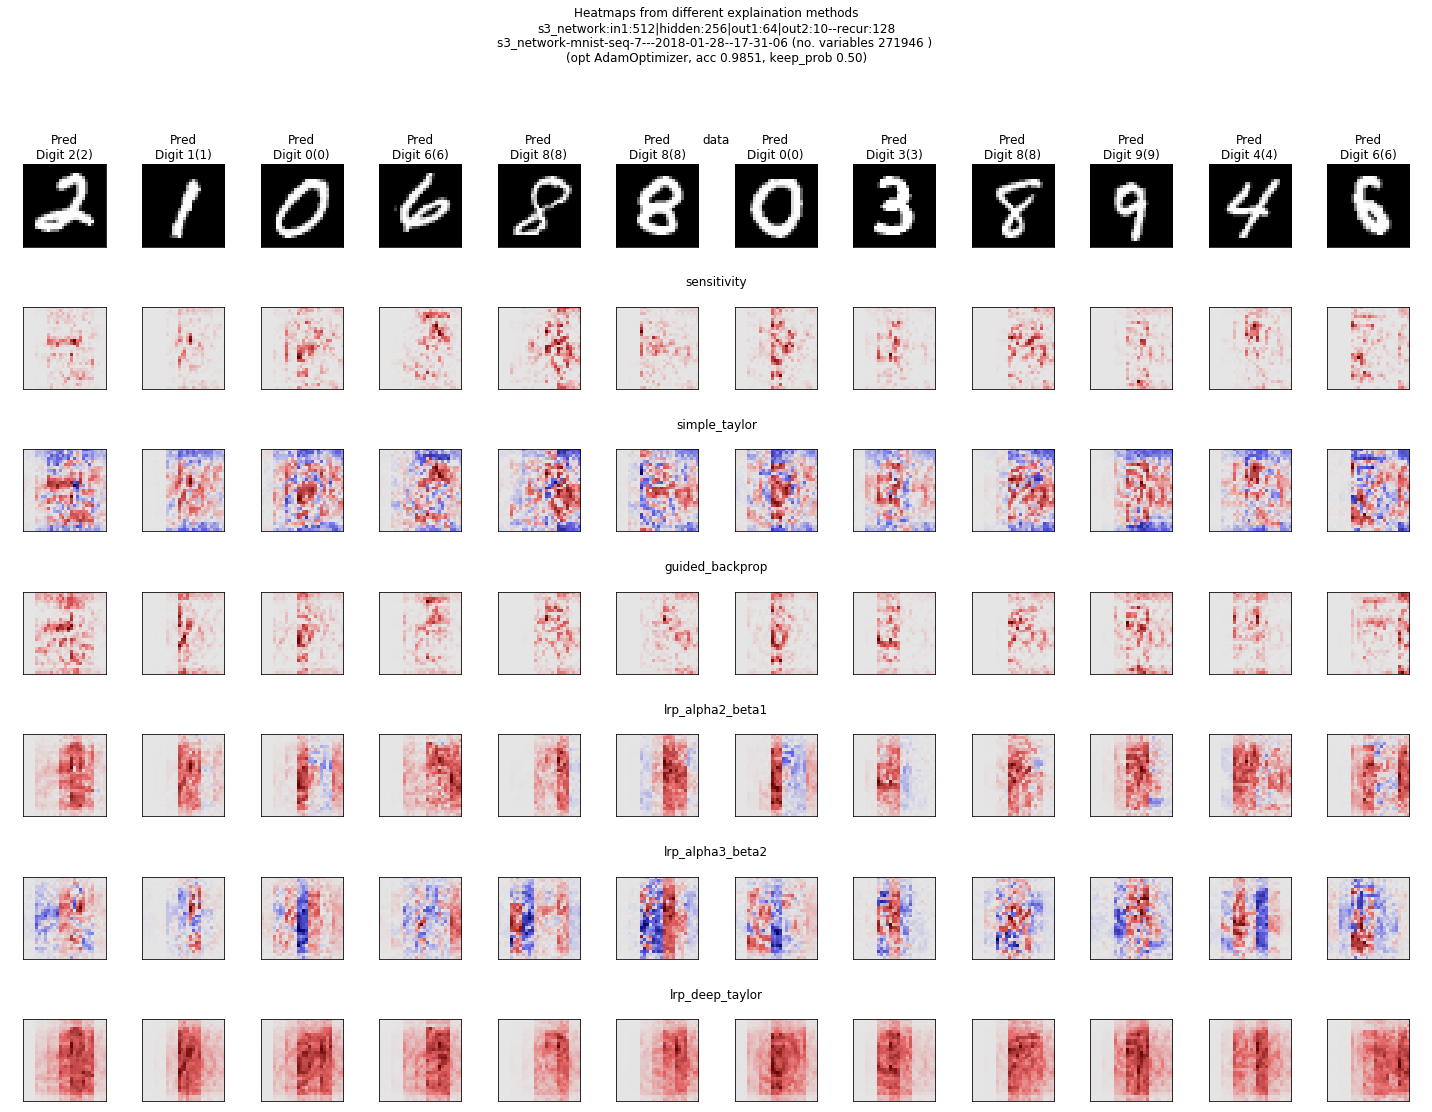

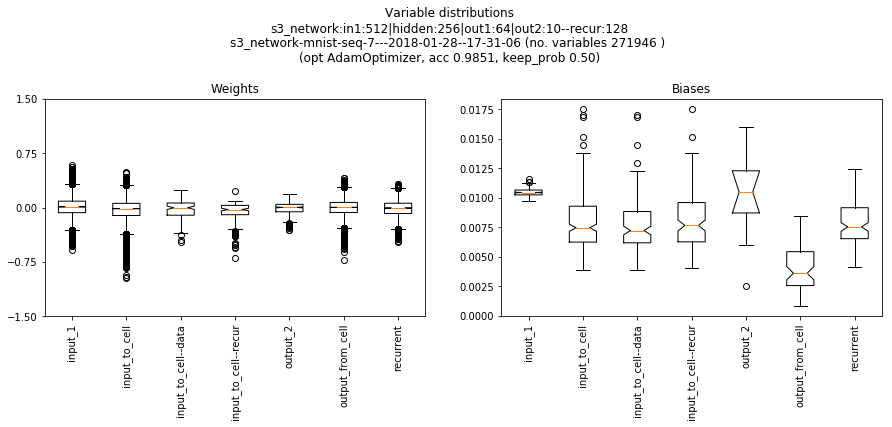

In [27]:
plot_everything('s3', 'mnist', 7)

Positive relevance for model deep_4l_network-mnist-seq-7---2018-01-28--19-31-55
relevance >= 0 : 1.000000


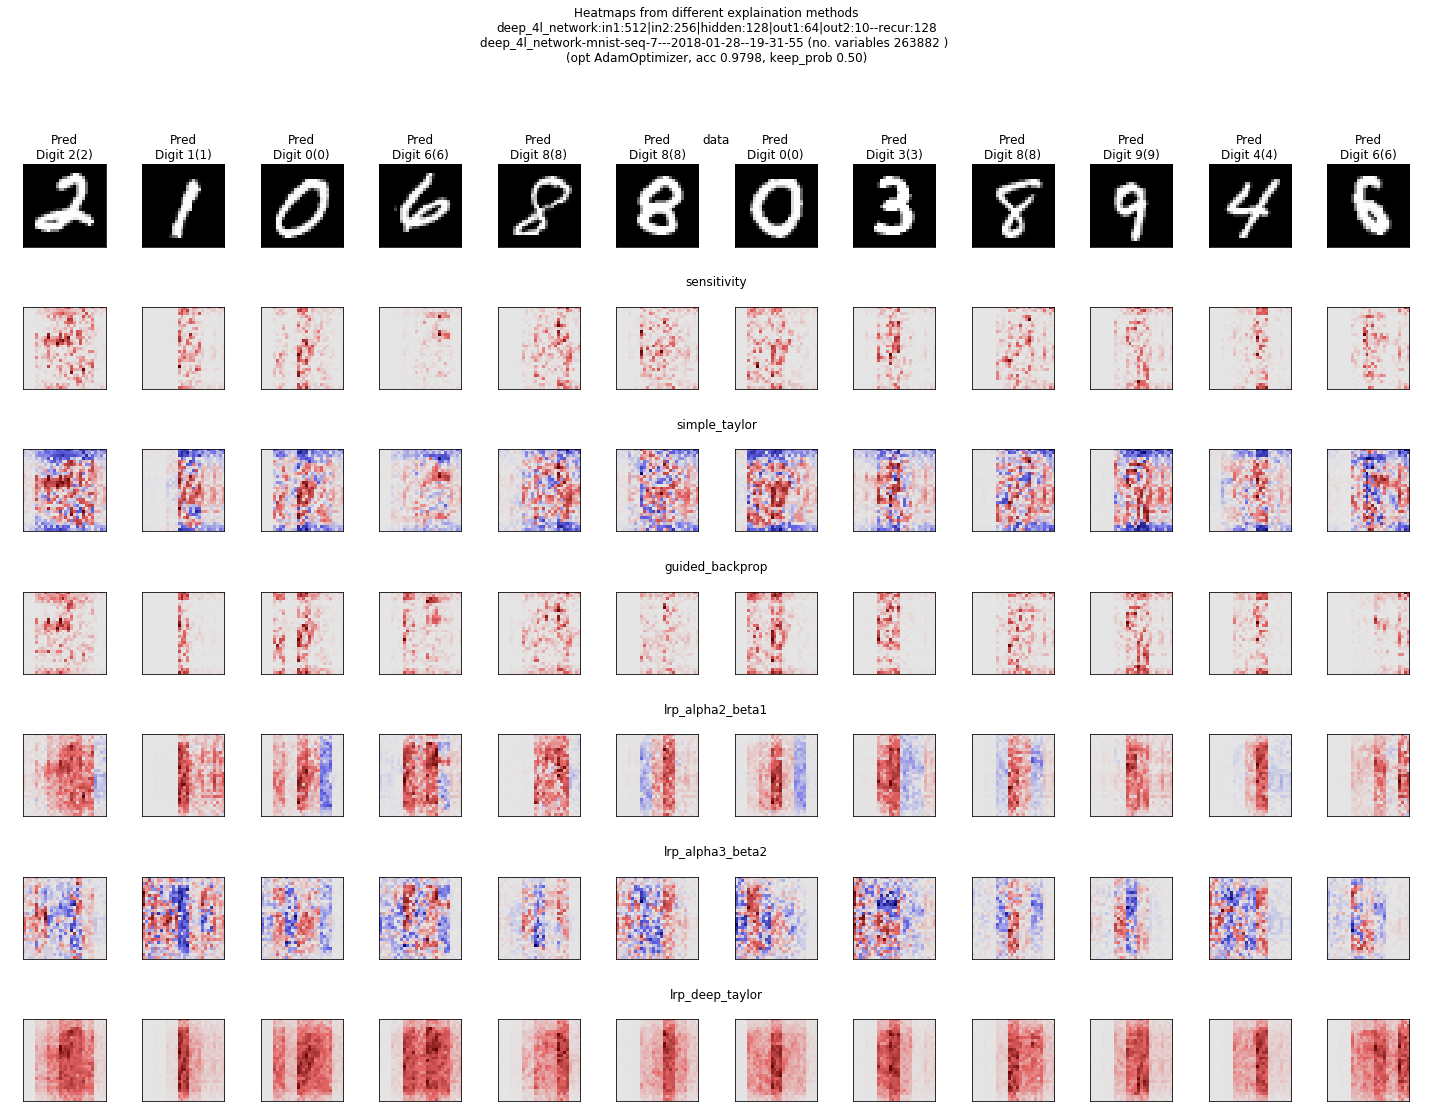

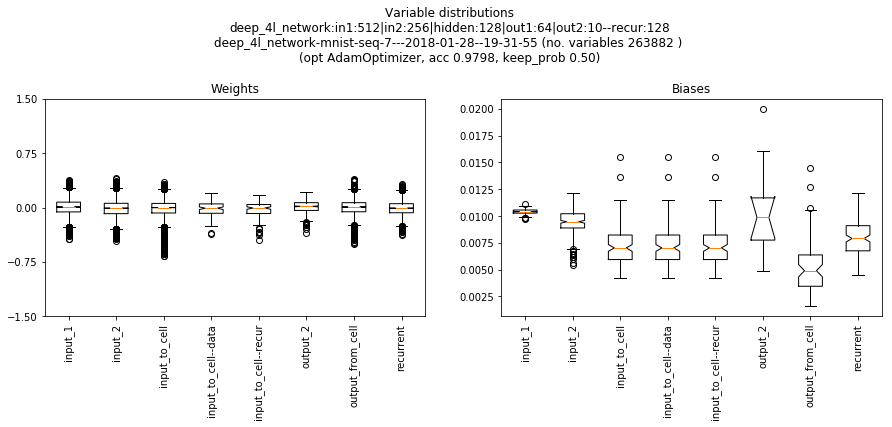

In [28]:
plot_everything('deep_4l', 'mnist', 7)

Positive relevance for model convdeep_4l_network-mnist-seq-7---2018-01-30--22-07-02
relevance >= 0 : 0.999700


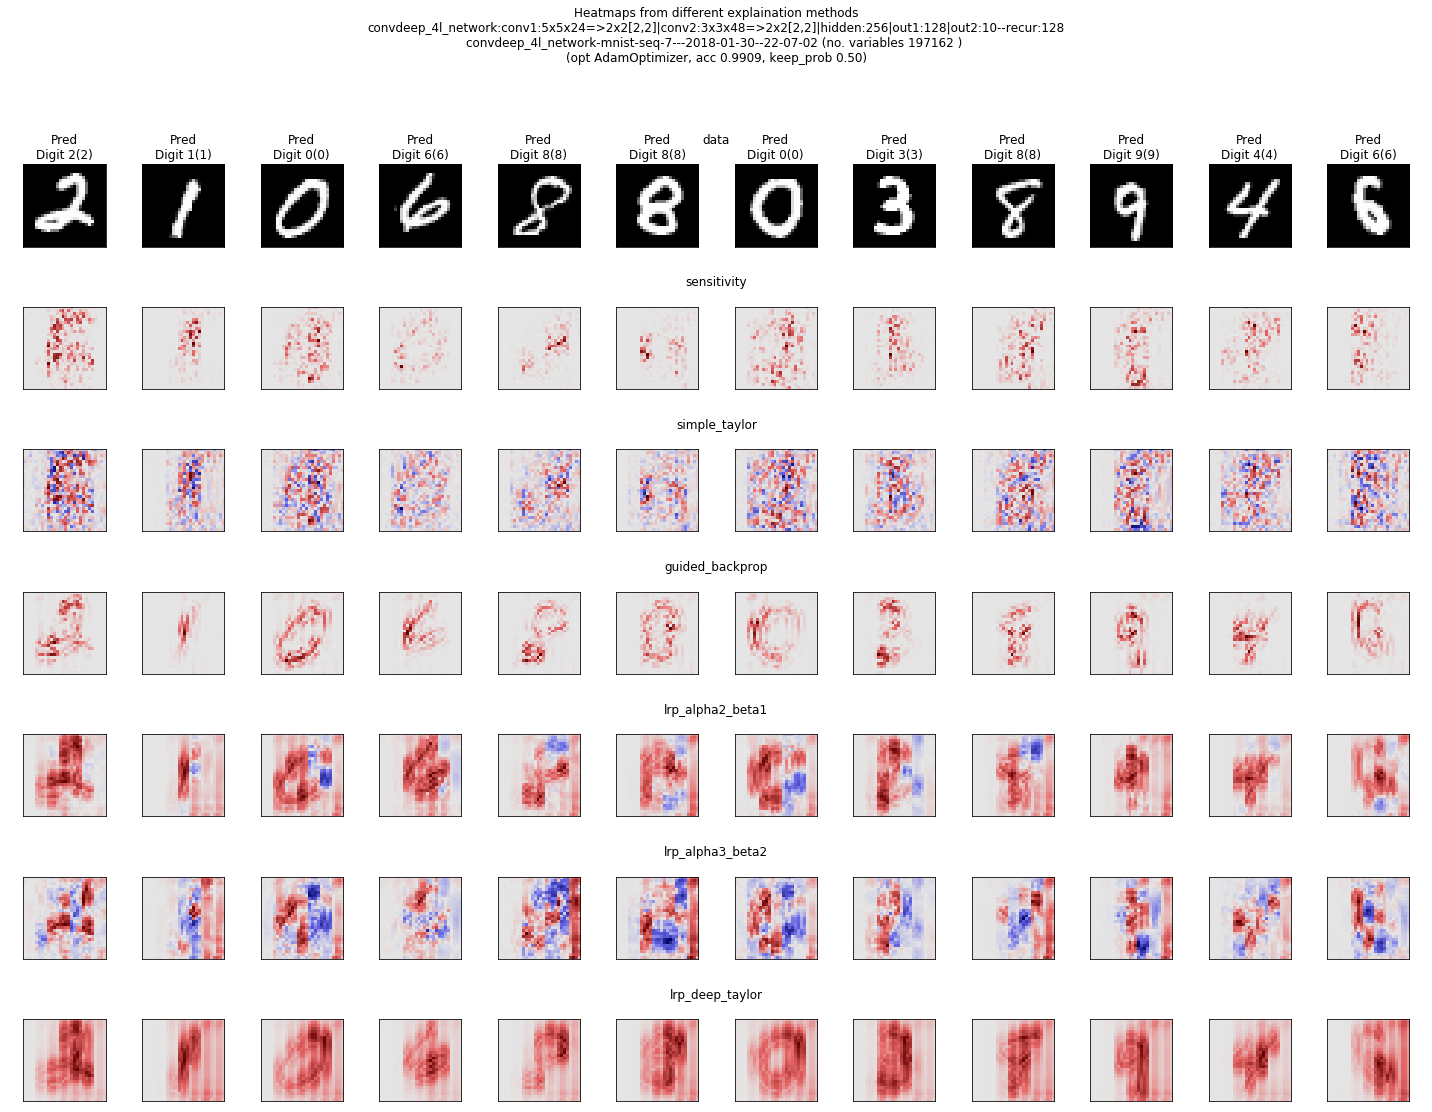

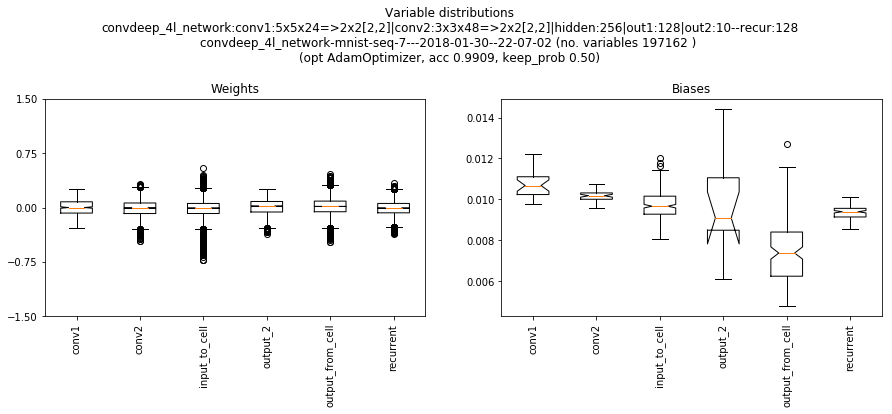

In [29]:
plot_everything('convdeep_4l', 'mnist', 7)

### FashionMNIST

Positive relevance for model s2_network-fashion-mnist-seq-7---2018-01-28--16-35-37
relevance >= 0 : 0.987300


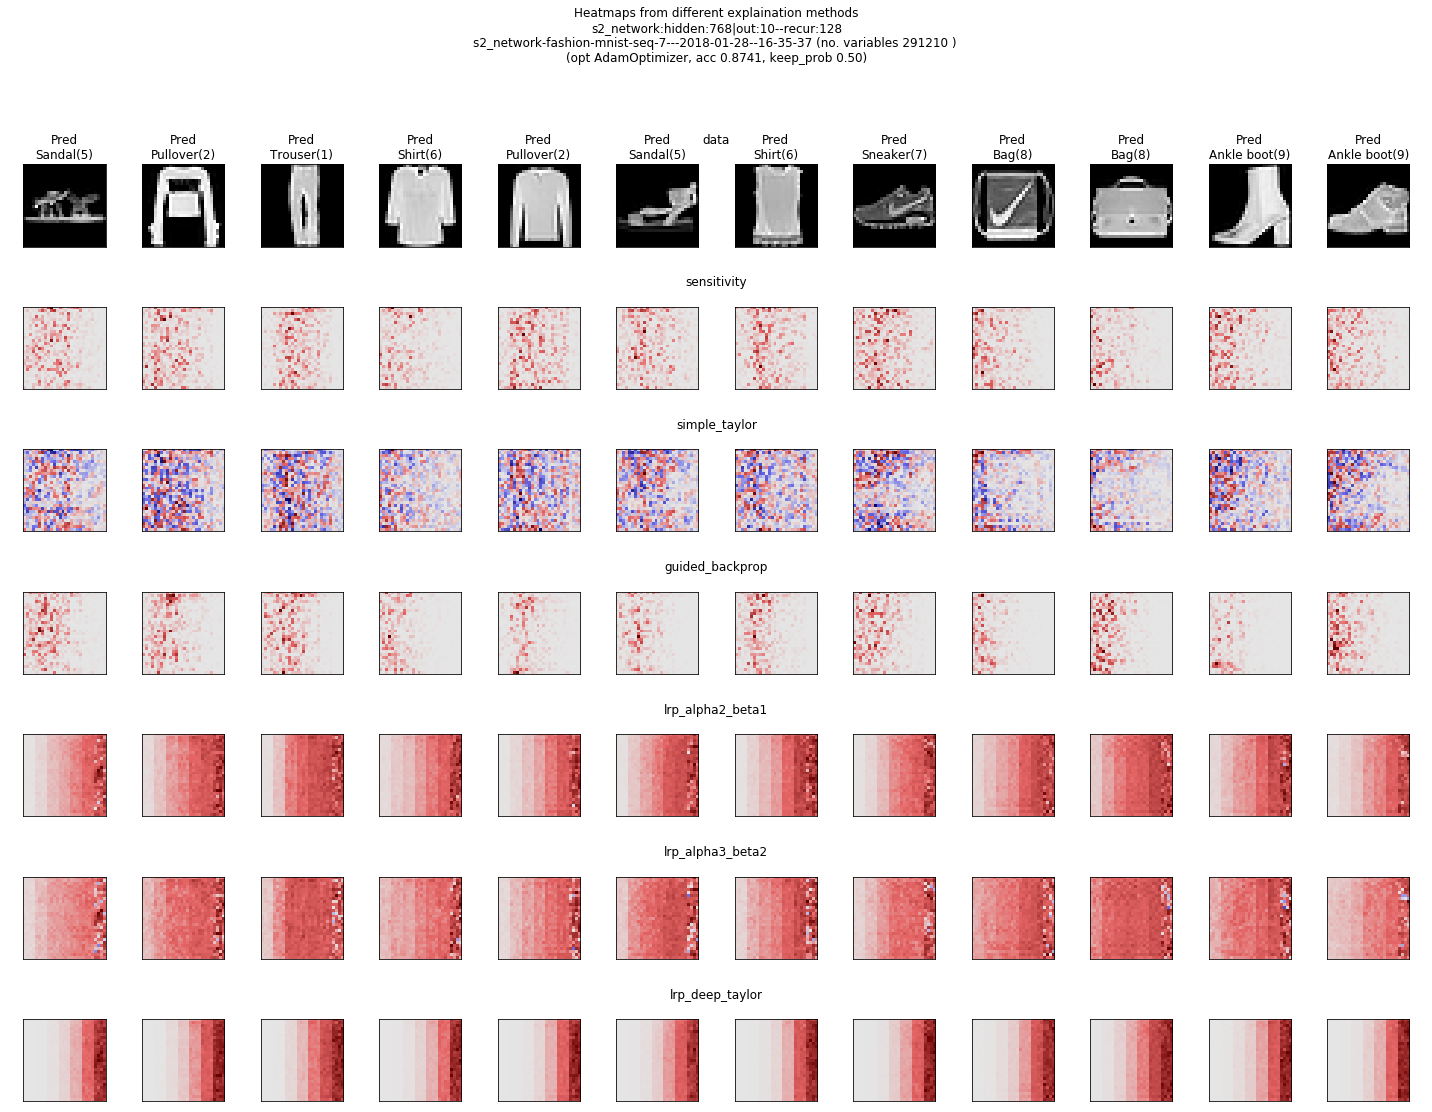

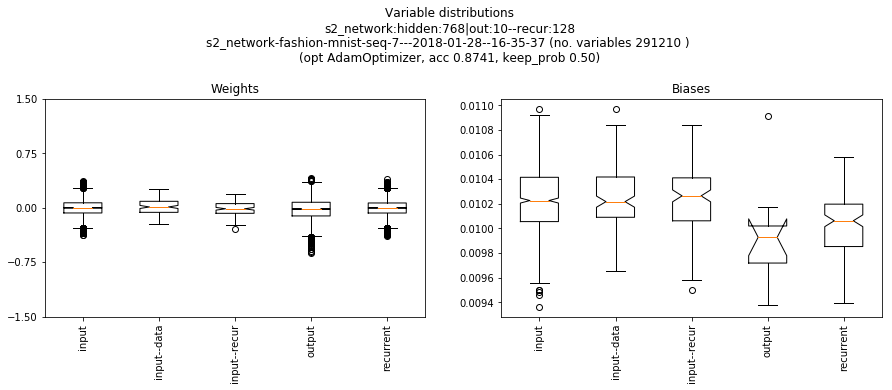

In [30]:
plot_everything('s2', 'fashion-mnist', 7)

Positive relevance for model s3_network-fashion-mnist-seq-7---2018-01-28--18-28-04
relevance >= 0 : 0.999800


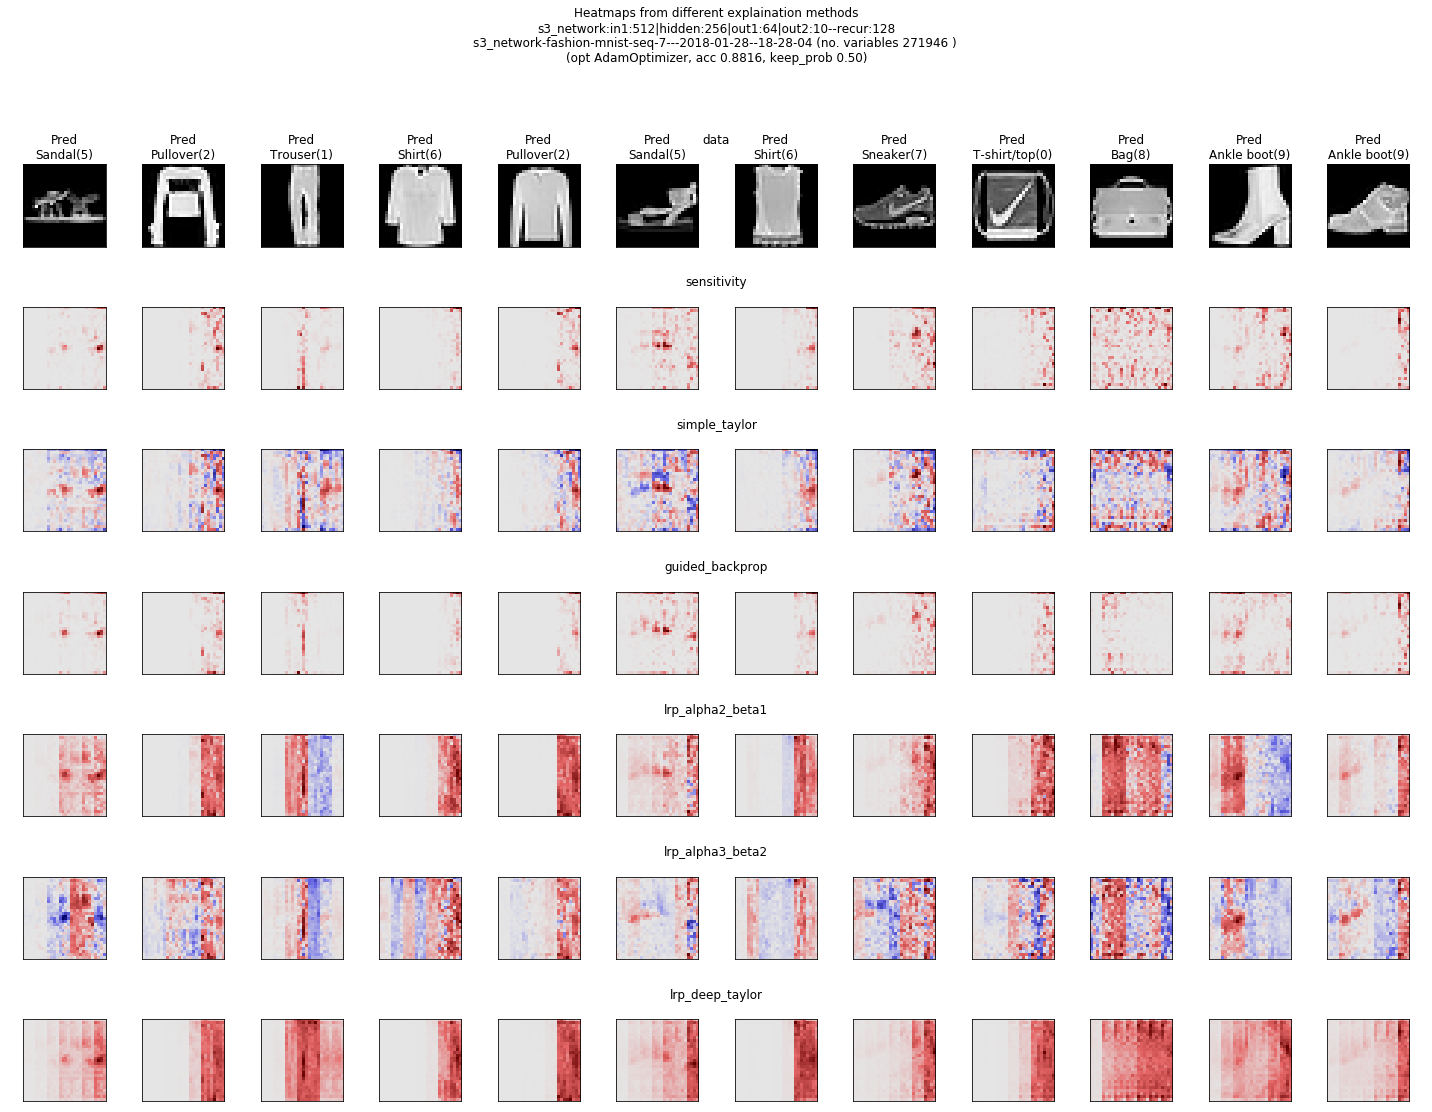

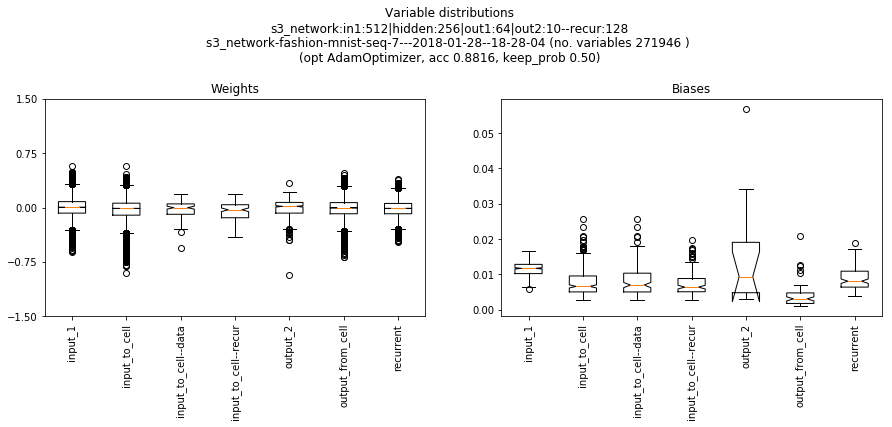

In [31]:
plot_everything('s3', 'fashion-mnist', 7)

Positive relevance for model deep_4l_network-fashion-mnist-seq-7---2018-01-28--20-38-57
relevance >= 0 : 0.999800


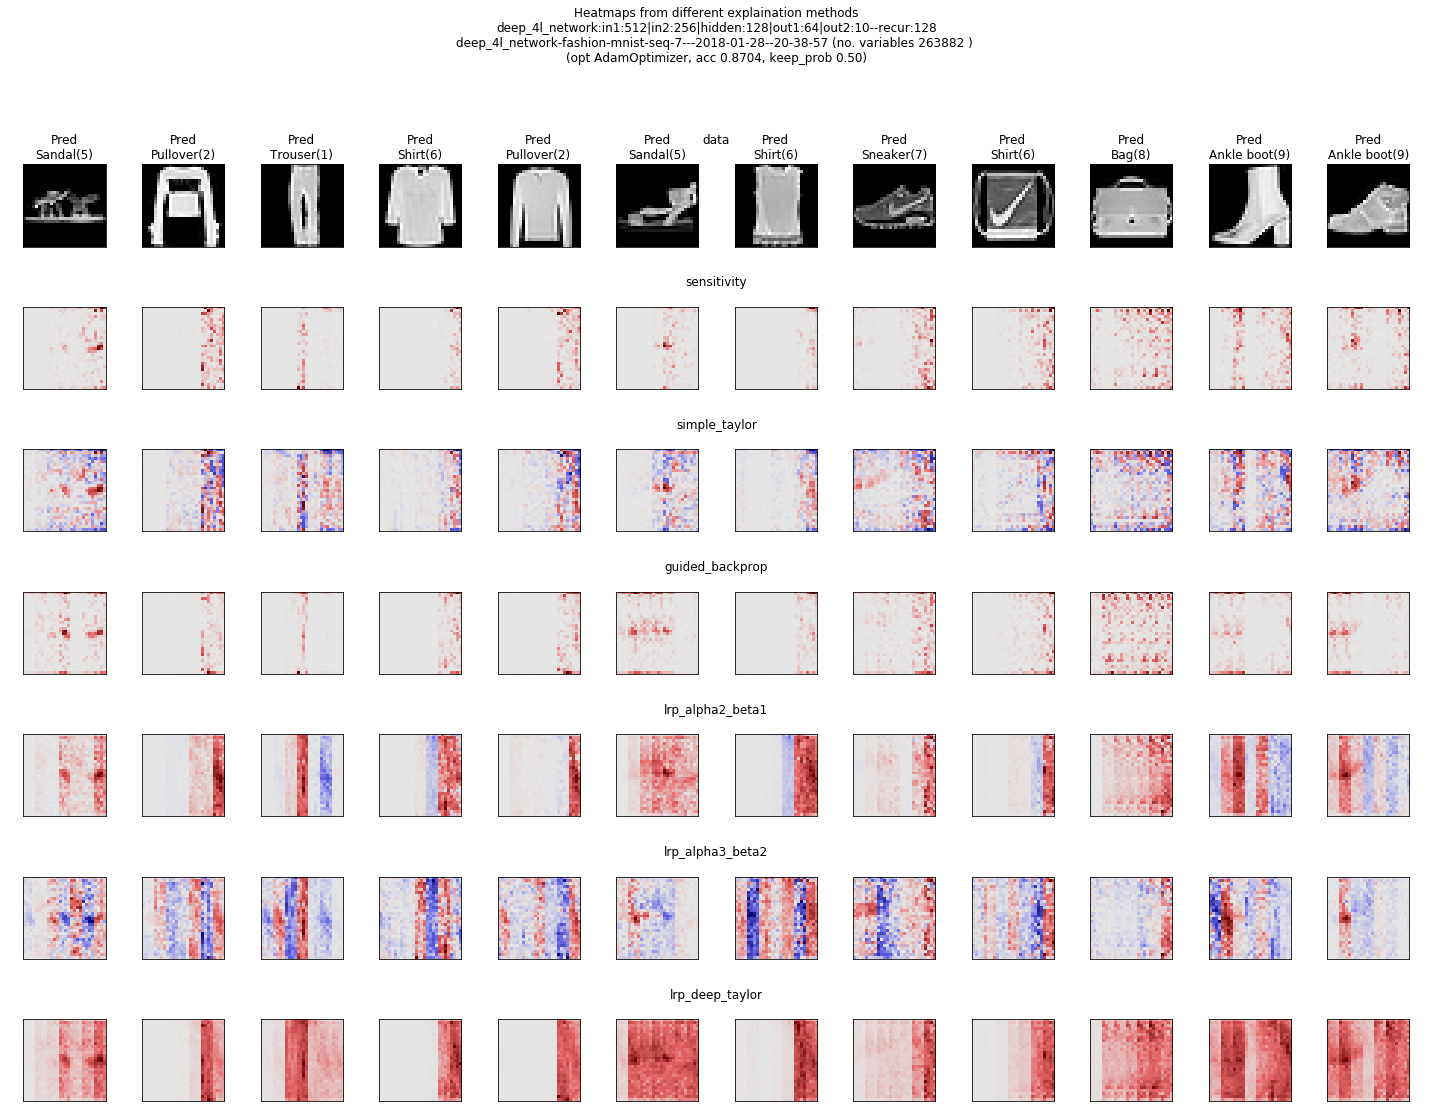

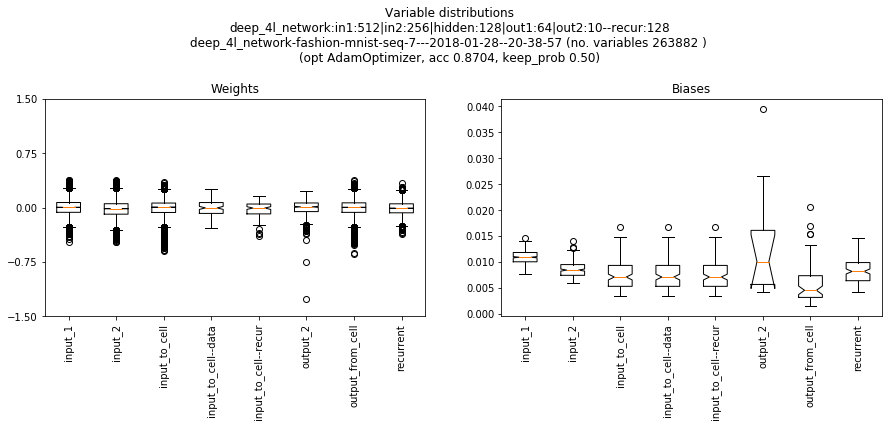

In [32]:
plot_everything('deep_4l', 'fashion-mnist', 7)

Positive relevance for model convdeep_4l_network-fashion-mnist-seq-7---2018-01-31--10-47-43
relevance >= 0 : 0.999700


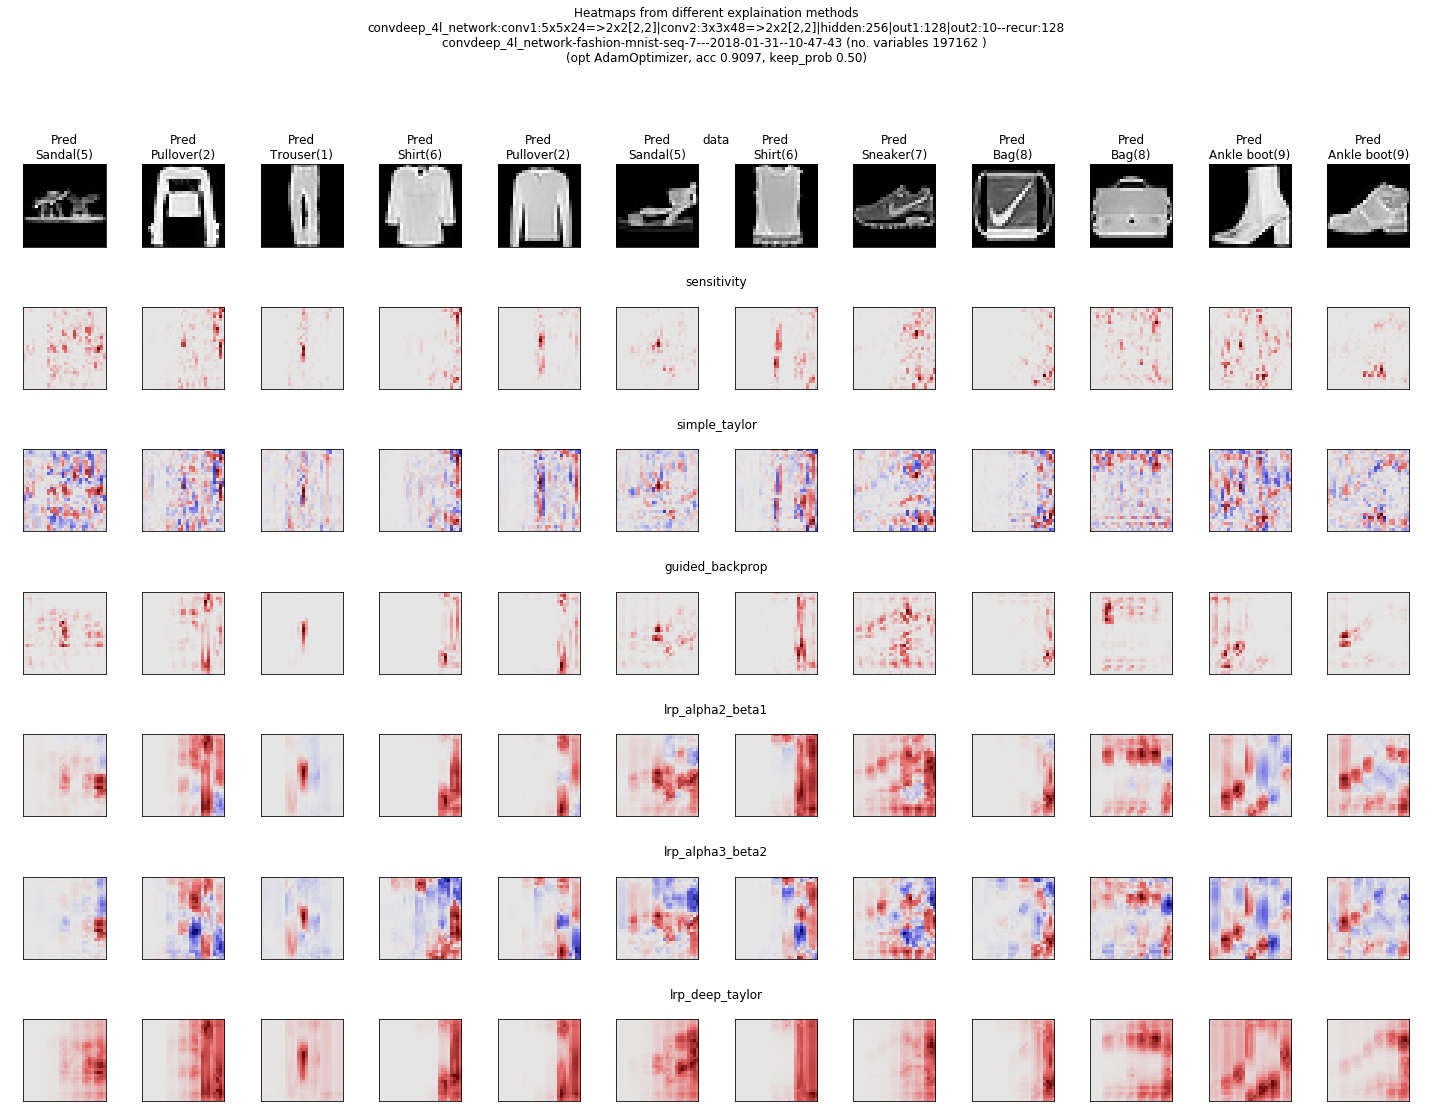

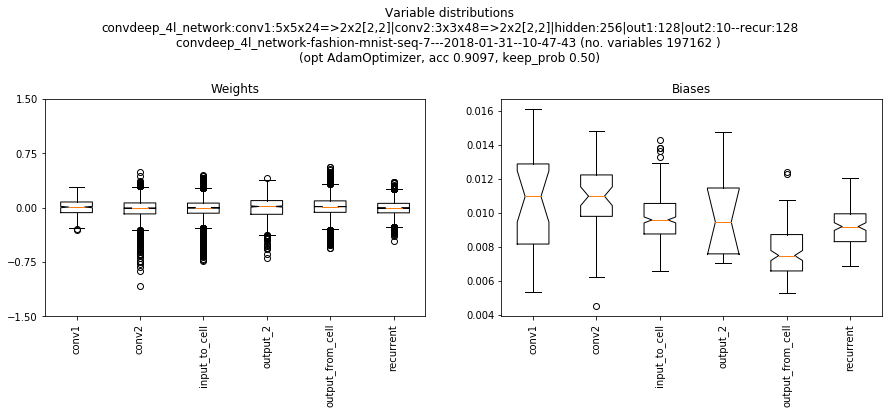

In [33]:
plot_everything('convdeep_4l', 'fashion-mnist', 7)

## Seq 14

### MNIST

In [34]:
# plot_everything('s2', 'mnist', 14)

In [35]:
# plot_everything('s3', 'mnist', 14)

In [36]:
# plot_everything('deep_4l', 'mnist', 14)

In [1]:
plot_everything('convdeep_4l', 'mnist', 14)

NameError: name 'plot_everything' is not defined

### FashionMNIST

In [38]:
# plot_everything('s2', 'fashion-mnist', 14)

In [39]:
# plot_everything('s3', 'fashion-mnist', 14)

In [40]:
# plot_everything('deep_4l', 'fashion-mnist', 14)

In [41]:
# plot_everything('convdeep_4l', 'fashion-mnist', 14)